<a href="https://colab.research.google.com/github/erzar0/engineering-thesis/blob/main/proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Dec  3 03:49:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[('Cu', 1.0), ('Pb', 1.0), ('K', 0.0), ('Ca', 0.0), ('Ti', 0.0), ('V', 0.0), ('Cr', 0.0), ('Mn', 0.0), ('Fe', 0.0), ('Co', 0.0), ('Ni', 0.0), ('Zn', 0.0), ('As', 0.0), ('Se', 0.0), ('Cd', 0.0), ('Sn', 0.0), ('Sb', 0.0), ('Au', 0.0), ('Hg', 0.0), ('Bi', 0.0)]


[[<matplotlib.lines.Line2D at 0x780b77a167a0>],

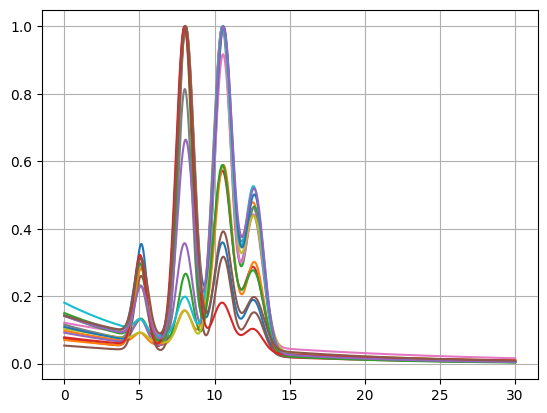

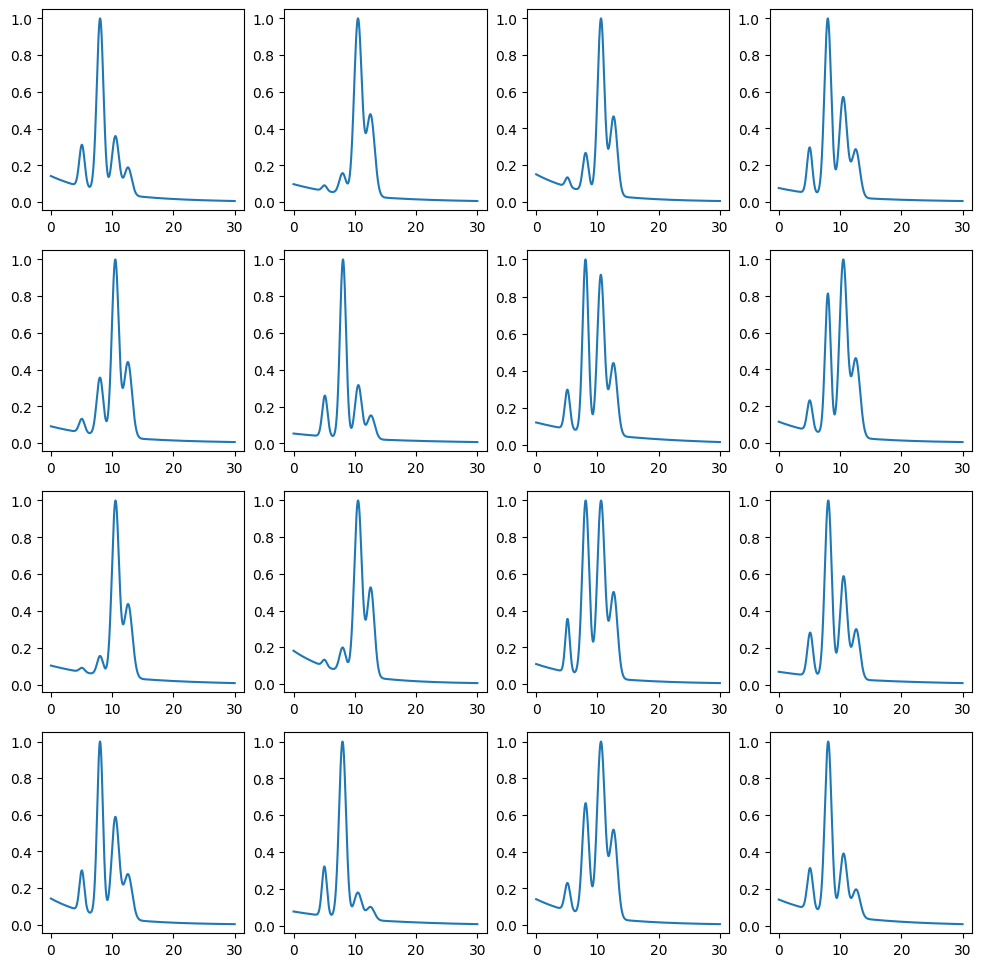

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from collections import defaultdict

plt.grid(True)

num2elem = defaultdict(str)
# num2elem.update({
#     0 : "ca"
#     , 1 : "cu"
#     , 2 : "zn"
#     , 3 : "fe"
#     , 4 : "pb"
# })

# element_lines = {
#     0 : (("k_alpha", 3.69, 0.5), ("k_beta", 4.01, 0.5),)
#     , 1 : (("k_alpha", 8.04, 1), ("k_beta", 8.91, 0.4))
#     , 2 : (("k_alpha", 8.64, 1), ("k_beta", 9.57, 0.2))
#     , 3 : (("k_alpha", 6.4, 1), ("k_beta", 7.06, 0.1))
#     , 4 : (("l_alpha", 10.5, 1), ("l_beta", 12.6, 0.9), ("m_alpha", 2.82, 0.01), ("m_beta", 3.16, 0.01))
# }

num2elem.update({
    0: "K"
    , 1:"Ca"
    , 2: "Ti"
    , 3: "V"
    , 4: "Cr"
    , 5: "Mn"
    , 6: "Fe"
    , 7: "Co"
    , 8: "Ni"
    , 9: "Cu"
    , 10: "Zn"
    , 11: "As"
    , 12: "Se"
    , 13: "Cd"
    , 14: "Sn"
    , 15: "Sb"
    , 16: "Au"
    , 17: "Hg"
    , 18: "Pb"
    , 19: "Bi"
})

element_lines = {
    0: (("k_alpha", 3.314, 1), )
    , 1: (("k_alpha", 3.692, 1), )
    , 2: (("k_alpha", 4.512, 1), )
    , 3: (("k_alpha", 4.953, 1), ("k_alpha_esc", 1.995, 0.2))
    , 4: (("k_alpha", 5.415, 1), ("k_alpha_esc", 2.457, 0.2))
    , 5: (("k_alpha", 5.900, 1), ("k_alpha_esc", 2.942, 0.2))
    , 6: (("k_alpha", 6.405, 1), ("k_alpha_esc", 3.447, 0.2))
    , 7: (("k_alpha", 6.931, 1), ("k_alpha_esc", 3.973, 0.2))
    , 8: (("k_alpha", 7.480, 1), ("k_alpha_esc", 4.522, 0.2))
    , 9: (("k_alpha", 8.046, 1), ("k_alpha_esc", 5.088, 0.2))
    , 10: (("k_alpha", 8.637, 1), ("k_alpha_esc", 5.679, 0.2))
    , 11: (("k_alpha", 10.543, 1), ("k_alpha_esc", 7.585, 0.2))
    , 12: (("k_alpha", 11.224, 1), ("k_alpha_esc", 8.266, 0.2))
    , 13: (("l_alpha", 3.133, 1), )
    , 14: (("l_alpha", 3.444, 1), )
    , 15: (("l_alpha", 3.604, 1), )
    , 16: (("l_alpha", 9.713, 1), ("l_beta", 11.443, 0.5))
    , 17: (("l_alpha", 9.989, 1), ("l_beta", 11.824, 0.5))
    , 18: (("l_alpha", 10.551, 1), ("l_beta", 12.614, 0.5))
    , 19: (("l_alpha", 10.839, 1), ("l_beta", 13.023, 0.5))
}


TARGET_VECTOR_LENGTH = len(element_lines.keys())
MIN_ENERGY = 0
MAX_ENERGY = 30
CHANNELS_COUNT = 4096

DETECTOR_BASE_SIGMA = 0.5
DETECTOR_SIGMA_COEF = 0.005
FANO = 8.503354916285307

def gaussian(x, mu, sigma):
    return  np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def get_random_percentages(n):
    random_percentages = np.random.uniform(0, 1, n)
    random_percentages /= np.sum(random_percentages)
    return random_percentages

def calculate_sigma(energy, use_fano=False):
    if use_fano:
        return np.sqrt((0.08/2.354)**2 + 0.00385 * FANO * energy)
    return DETECTOR_BASE_SIGMA - energy * DETECTOR_SIGMA_COEF

def generate_training_data(element_lines, mu_max_err = 0.000, sigma_max_err = 0.00, mu_max_err_global = 0.00, samples = 10, elements_per_sample = 3, element_numbers = None):
    X = [np.zeros(CHANNELS_COUNT) for i in range(samples)]
    y = [np.zeros(TARGET_VECTOR_LENGTH) for i in range(samples)]
    linspace = np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT)

    for i in range(samples):
        if element_numbers is None:
            selected_element_numbers = random.sample(sorted(element_lines), elements_per_sample)
        else:
            selected_element_numbers = element_numbers
        element_percentages = get_random_percentages(len(selected_element_numbers))
        mu_err_global = np.random.uniform(-mu_max_err_global, mu_max_err_global)

        for element_percentage, element_number in zip(element_percentages, selected_element_numbers):
            y[i][element_number] = 1
            # y[i][element_number] = element_percentage
            X_element = np.zeros(CHANNELS_COUNT)
            intensity_norm_coeff = 0

            for element_line in element_lines[element_number]:
                mu = element_line[1] + np.random.uniform(-mu_max_err, mu_max_err) + mu_err_global
                sigma = calculate_sigma(mu, use_fano=True) + np.random.uniform(-sigma_max_err, sigma_max_err)
                gauss = gaussian(linspace, mu, sigma)

                intensity = element_line[2]
                intensity_norm_coeff += intensity
                X_element += gauss * intensity


            X_element /= intensity_norm_coeff
            X_element /= np.max(X_element)
            X_element *= element_percentage
            X[i] += X_element

        X[i] /= np.max(X[i])
        X[i] += np.exp(-np.linspace(np.random.uniform(1.5, 3), np.random.uniform(4, 6), CHANNELS_COUNT))
        X[i] /= np.max(X[i])

    return X, y

def print_y(target):
    percentages = defaultdict(float)
    for i in range(TARGET_VECTOR_LENGTH):
        percentages[i] = target[i]
    percentages = sorted(percentages.items(), key=lambda item: item[1], reverse=True)
    percentages = [(num2elem[k], v) if k in num2elem else ('', v) for k, v in percentages]
    print(percentages)

example_X, example_y = generate_training_data(element_lines, mu_max_err = 0.005, sigma_max_err = 0.05, mu_max_err_global = 0.05, samples=100,  elements_per_sample=10, element_numbers = [9, 18])

example_X = np.asarray(example_X)
example_y = np.asarray(example_y)
print_y(example_y[0])

[plt.plot(np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT), example_X[i*4 + j]) for i in range(4) for j in range(4)]

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
[axs[i][j].plot(np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT), example_X[i*4 + j]) for i in range(4) for j in range(4)]


In [ ]:
print(np.argmax(example_X))
print(example_X[0][1182])

1004
0.6400829940487452


In [ ]:
!pip install graphviz
!apt-get install graphviz
!pip install torchview

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
import torch
import tqdm
import graphviz
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torchview import draw_graph
from graphviz import Source


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv1d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm1d(intermediate_channels)
        self.conv2 = nn.Conv1d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(intermediate_channels)
        self.conv3 = nn.Conv1d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm1d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * 4, num_classes)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        print(x.shape)
        x = self.avgpool(x)
        print(x.shape)

        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return self.sigmoid(x)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv1d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm1d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(num_classes=TARGET_VECTOR_LENGTH, num_channels=1):
    return ResNet(block, [3, 4, 6, 3], num_channels, num_classes)

def test():
    BATCH_SIZE = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet50(num_channels=1, num_classes=TARGET_VECTOR_LENGTH).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, CHANNELS_COUNT).to(device))
    assert y.size() == torch.Size([BATCH_SIZE, TARGET_VECTOR_LENGTH])
    print(y.size())

graph = draw_graph(ResNet50(num_channels=1, num_classes=TARGET_VECTOR_LENGTH), input_size=(128, 1, 4096), expand_nested=True)
# graphviz.set_jupyter_format('png')
# graph.visual_graph


torch.Size([128, 2048, 128])
torch.Size([128, 2048, 1])


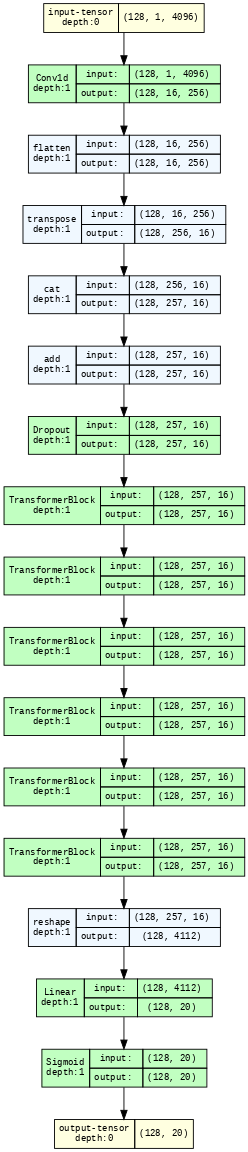

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate):
        super(VisionTransformer, self).__init__()

        num_patches = input_size // patch_size
        self.patch_embed = nn.Conv1d(1, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)
        ])

        # Classifier head
        self.fc = nn.Linear(embed_dim + input_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x)

        # Classification head
        # x = x.mean(dim=1)
        x = self.fc(x.reshape(x.size(0), -1))
        x = self.sigmoid(x)
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate):
        super(TransformerBlock, self).__init__()

        self.attn_weights = None

        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, attn_weights = self.attention(x, x, x)
        self.attn_weights = attn_weights
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        ff_output = self.feedforward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        return x


# Training loop
# def train(model, train_loader, criterion, optimizer, num_epochs):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Define hyperparameters
input_size = 4096
patch_size = 16
embed_dim = 16
num_heads = 8
num_classes = 20
num_layers = 6
hidden_dim = 4 * embed_dim
dropout_rate = 0.1

model = VisionTransformer(input_size, patch_size, embed_dim, num_heads, num_classes, num_layers, hidden_dim, dropout_rate)

graph = draw_graph(model, input_size=(128, 1, 4096), expand_nested=True, depth=1)
graphviz.set_jupyter_format('png')
graph.visual_graph


In [ ]:
!nvidia-smi
!export CUDA_LAUNCH_BLOCKING=1

Tue Dec  5 21:26:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    38W / 300W |   3248MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import copy
from functools import reduce
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(X, y, device, batch_size=16, shuffle=True):
    X_train_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train(model, train_loader, test_loader, optimizer, criterion, epochs = 3):
    best_loss = np.inf
    best_weights = None
    train_history = []
    test_history = []
    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch}")
        train_loss = 0
        idx = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            idx += 1
            train_loss += float(loss)
            if idx % 10 == 0:
                print(f"Batch {idx}, loss: {float(loss)}")

        train_loss = train_loss/idx
        print("train epoch avg loss: %.2f" % train_loss)
        train_history.append(train_loss)

        with torch.no_grad():
            model.eval()
            def _calc_loss(dataloader):
                loss_acc = 0
                for X_batch, y_batch in dataloader:

                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss_acc += float(loss)
                return loss_acc / len(dataloader)

            test_loss = _calc_loss(test_loader)
            print("test loss: %.2f" % test_loss)
            test_history.append(test_loss)
            if test_loss < best_loss:
                best_loss = test_loss
                best_weights = copy.deepcopy(model.state_dict())

    return train_history, test_history, best_loss, best_weights



BATCH_SIZE = 128
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

artificial_data = [generate_training_data(element_lines, mu_max_err = 0.002, sigma_max_err = 0.08, mu_max_err_global=0.05, samples = (10000 - i * 1000) ,  elements_per_sample = i, element_numbers = None) for i in range(1, 10)]
X, y = reduce(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]) , artificial_data, ([], []))
X = np.asarray(X).reshape(-1, 1, CHANNELS_COUNT)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
train_loader = create_dataloader(X_train, y_train, DEVICE, batch_size=BATCH_SIZE, shuffle=True)
test_loader = create_dataloader(X_test, y_test, DEVICE, batch_size=BATCH_SIZE, shuffle=True)

model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_history, test_history, best_loss, best_weights = train(model, train_loader, test_loader, optimizer, criterion, epochs = EPOCHS)

model.load_state_dict(best_weights)

# model_graph = draw_graph(model, input_size=(batch_size, 1, 4096), device='meta')
# graph = model_graph.visual_graph
# graph.render("model_graph", format="svg", cleanup=True)

Epoch 0
Batch 10, loss: 0.24783359467983246
Batch 20, loss: 0.2730114459991455
Batch 30, loss: 0.2539551854133606
Batch 40, loss: 0.25500360131263733
Batch 50, loss: 0.2168564349412918
Batch 60, loss: 0.25625932216644287
Batch 70, loss: 0.27445974946022034
Batch 80, loss: 0.25589635968208313
Batch 90, loss: 0.2678650915622711
Batch 100, loss: 0.23969145119190216
Batch 110, loss: 0.26593077182769775
Batch 120, loss: 0.24563811719417572
Batch 130, loss: 0.28952038288116455
Batch 140, loss: 0.24217823147773743
Batch 150, loss: 0.23216281831264496
Batch 160, loss: 0.2757183611392975
Batch 170, loss: 0.24558329582214355
Batch 180, loss: 0.22671614587306976
Batch 190, loss: 0.2606423795223236
Batch 200, loss: 0.26968076825141907
Batch 210, loss: 0.2280876636505127
Batch 220, loss: 0.22846999764442444
Batch 230, loss: 0.25644153356552124
Batch 240, loss: 0.23823781311511993
Batch 250, loss: 0.24677860736846924
Batch 260, loss: 0.21569779515266418
Batch 270, loss: 0.23627470433712006
Batch 280

<All keys matched successfully>

loss: 0.16


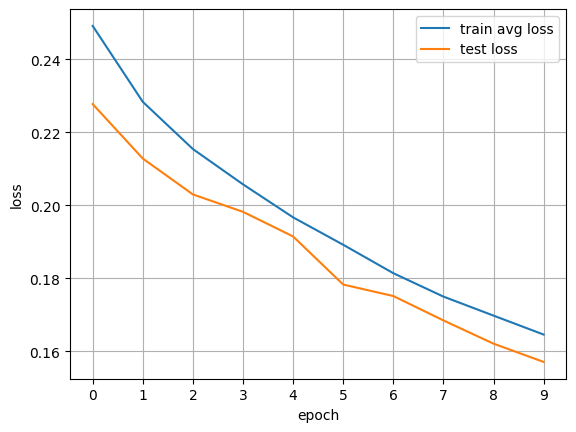

In [ ]:
print("loss: %.2f" % best_loss)

plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(range(len(train_history)))
plt.plot(train_history, label="train avg loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


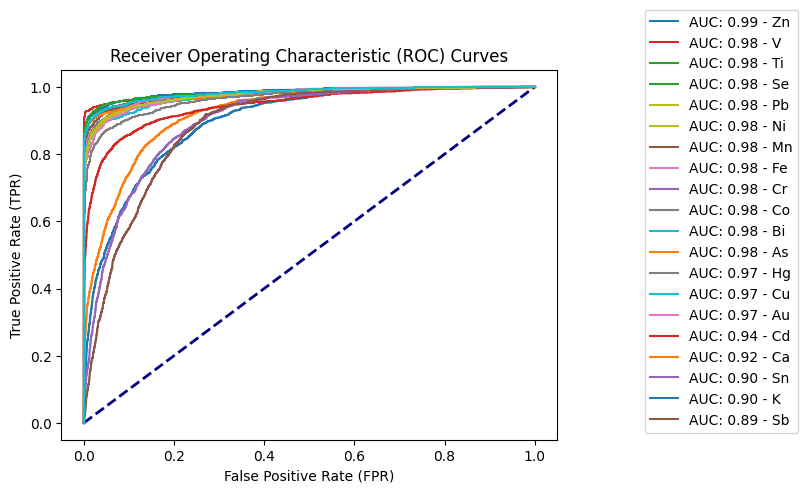

Avg auc: 0.9611363220672601


In [ ]:
from sklearn.metrics import roc_curve, auc
def calculate_roc(testloader):

    pred_labels = [[] for i in range(TARGET_VECTOR_LENGTH)]
    real_labels = [[] for i in range(TARGET_VECTOR_LENGTH)]
    with torch.no_grad():
        model.eval()
        for X_batch, y_batch in test_loader:
            for y in y_batch:
                for i, label in enumerate(y):
                    real_labels[i].append(label.to("cpu"))

            y_pred = model(X_batch)
            for y in y_pred:
                for i, label in enumerate(y):
                    pred_labels[i].append(label.to("cpu"))

    aucs = []
    handles_list = []
    labels_list = []
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    for i in tqdm(range(TARGET_VECTOR_LENGTH)):
        fpr, tpr, thresholds = roc_curve(real_labels[i], pred_labels[i])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        line, = plt.plot(fpr, tpr)

        handles_list.append(line)
        labels_list.append(f"AUC: {roc_auc:.2f} - {num2elem[i].capitalize()}")

    sorted_lists = sorted(zip(labels_list, handles_list), key = lambda x: x[0], reverse=True)
    sorted_lists = list(zip(*sorted_lists))
    plt.legend(handles=sorted_lists[1], labels=sorted_lists[0], loc='lower right', bbox_to_anchor=(1.5, 0))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.show()

    print(f"Avg auc: {sum(aucs)/len(aucs)}")


calculate_roc(test_loader)


In [ ]:
!nvidia-smi

Tue Dec  5 22:04:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    38W / 300W |   2904MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[('Cu', 0.9990476965904236), ('Zn', 0.7045593857765198), ('Ni', 0.019496478140354156), ('V', 0.010939442552626133), ('Cd', 0.004983569961041212), ('Ca', 0.003775052959099412), ('Hg', 0.003709266660735011), ('Ti', 0.003566343104466796), ('Au', 0.0034486791118979454), ('Sn', 0.003100115340203047), ('K', 0.002804646734148264), ('Sb', 0.0027772407047450542), ('Se', 0.002443725010380149), ('Cr', 0.0022843305487185717), ('Fe', 0.002174760214984417), ('Pb', 0.002076757373288274), ('As', 0.001996763050556183), ('Co', 0.001897646812722087), ('Bi', 0.0018599658505991101), ('Mn', 0.0003957688750233501)]
1107


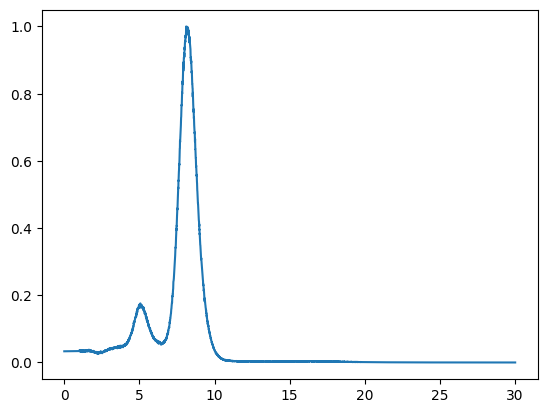

In [ ]:
N = 100
plt.figure(100)
with torch.no_grad():
    # y_pred = model(torch.tensor(X[N, 0].reshape((1, 1, 4096))).float().to(DEVICE))[0]
    # print_y(y_pred.tolist())
    # print_y(y[N].tolist())
    array = np.array([0.033322971849812796,0.033327663835421566,0.03333235641862011,0.03333704970711704,0.03334174362680966,0.03334643821855558,0.03335113347512269,0.033355829370478554,0.03336052596430065,0.03336522316362749,0.03336992109508522,0.03337461962488978,0.033379318868218245,0.0333840187362106,0.03338871928444183,0.03339342049100285,0.03339812234449824,0.033402824890008925,0.03340752804912997,0.03341223193397144,0.03341693641791777,0.033421641623633196,0.03342634744746315,0.033431053959737216,0.03343576112383218,0.03344046894302672,0.033445177447768176,0.033449886574245156,0.033454596420014686,0.03345930686564806,0.03346401804131546,0.03346872982853047,0.03347344231241448,0.033478155441592966,0.03348286923405589,0.03348758370557983,0.03349229880698408,0.03349701462123554,0.03350173103611082,0.033506448189304816,0.03351116594746187,0.033515884410532534,0.03352060351235371,0.033525323285663815,0.03353004373153156,0.03353476481544399,0.03353948660574087,0.033544209000618594,0.03354893213572726,0.03355365587239293,0.03355838032223658,0.033563105404269176,0.033567831166014916,0.033572557593797354,0.03357728466780851,0.03358201244172384,0.03358674082836385,0.03359146994879521,0.03359619967154567,0.03360093011575827,0.033605661185580595,0.033610392943360025,0.033615125360637634,0.03361985843234769,0.0336245921974641,0.033629326583468684,0.03363406169680754,0.03363879741322856,0.033643533859415695,0.033648270924615684,0.03365300868603651,0.03365774710039937,0.03366248617741815,0.0336672259413279,0.03367196633430898,0.033676707448149754,0.033681449165836694,0.03368619162161362,0.03369093468978881,0.03369567846246839,0.03370042288151621,0.03370516797146318,0.03370991374176814,0.03371466014934732,0.03371940727129402,0.033724154997851905,0.033728903470843515,0.03373365254960106,0.033738402341166436,0.03374315277250855,0.03374790388301286,0.03375265566732453,0.03375740809713307,0.03376216123479938,0.033766914984277537,0.0337716694756837,0.033776424572640434,0.03378118039072828,0.03378593684198368,0.03379069398068414,0.03379545178662367,0.0338002102463025,0.03380496940731175,0.033809729188334796,0.03381448970479946,0.033819250827581845,0.033824012679838554,0.03382877515863585,0.03383353833318099,0.03383830216837919,0.03384306666557895,0.03384783185756412,0.033852597677784826,0.03385736422694313,0.03386213138318728,0.03386689927726895,0.03387166779124646,0.033876437009294484,0.03388120688139182,0.03388597742377286,0.03389074865437659,0.03389552052145743,0.033900293110954216,0.033905066308305934,0.03390984025187836,0.033914614808684074,0.03391939007790291,0.03392416599454955,0.03392894258978194,0.03393371986665656,0.03393849778826974,0.03394327642575951,0.03394805567412082,0.033952835672613015,0.03395761627990459,0.03396239760797191,0.033967179576827704,0.0361988231574528,0.0345048912188177,0.03443260614870816,0.03550170622183811,0.034830365864338325,0.03626161579549276,0.032554425889776646,0.03367946057409966,0.03459292062208443,0.033897775709247194,0.03259654873896854,0.032787890142187304,0.034245440512960204,0.035070049261387584,0.03386481956926156,0.0363485865658871,0.03323422944190973,0.03457703776798568,0.03351150480238073,0.035232658146245203,0.031694482645120245,0.03185583643897138,0.03624220024397094,0.033236883159529745,0.03406115946306813,0.03484373016074573,0.033060623707022944,0.03166015388609058,0.03351834269000376,0.03476221625639828,0.031019286374667124,0.03153064555735963,0.035520180668525164,0.036927957662404705,0.03247553465396002,0.03368672157339963,0.03576468458359934,0.03322125971542311,0.036463538485916054,0.03382643929282469,0.03546871313756404,0.03460467556286608,0.03329226200645013,0.03405675114685499,0.031521200125763836,0.033953218361705735,0.03344305465232064,0.03392048636793024,0.03433627474516011,0.0342887823356964,0.03361116993788505,0.03329764415709353,0.033705320270150135,0.036680139327771887,0.034757709724544866,0.03238434026194128,0.0347463099020626,0.03315950052951216,0.03649594558365478,0.03510021652382453,0.033707329237216026,0.03384805941586624,0.03535556030926899,0.034357429770716846,0.03342894402870605,0.034734268690039066,0.03592285156896812,0.03423172277875984,0.03562446063456162,0.03601786911749107,0.03316234566374675,0.035429378339094326,0.034398124597858945,0.03612070092225378,0.03503306091639214,0.035127144082106154,0.03586689177703177,0.036511508583236124,0.03285211835112947,0.03449061017149237,0.03409145097556859,0.03544083524508895,0.03562386205765471,0.03533264564359965,0.03531666121284782,0.0350456654415406,0.0346600208265109,0.038134583473811524,0.03479575670241269,0.03402008601738991,0.03492070645729728,0.03630828044032008,0.03380605326788556,0.034563364526926064,0.03280062563942508,0.0347626561731397,0.03527403381454973,0.03584366397887095,0.03309925248358692,0.035618460594613835,0.03641935126665236,0.03307891345912134,0.03373783566656775,0.0344830435885531,0.03468889018530731,0.03348842811553312,0.03485144030614587,0.03588040382373941,0.03333111156821113,0.03391193922853483,0.03496068768682762,0.03351551518766019,0.033059870657789925,0.031421159732736265,0.031948350554361085,0.03233887613194096,0.03380390577987814,0.034216802849226194,0.031955846609736355,0.032653416052464114,0.032251233749742744,0.031226496361106557,0.03440937835054735,0.03244230902094349,0.03106605595716037,0.03139211490870988,0.03268094554866562,0.031709432796916515,0.03328726602319508,0.034569417462546805,0.030388170705305105,0.03056474414398347,0.03143296588868462,0.03150991783131926,0.030697409912614326,0.032291401354368254,0.03130679966758842,0.02977031943620411,0.02918760705887798,0.02998757175063974,0.030644521908455267,0.031874398191433506,0.029800733518261492,0.02853085837386214,0.030655288743928838,0.030970369304166457,0.031214849719003828,0.02990520572773907,0.03015281418703987,0.02973946629108512,0.03023552020368203,0.03173714194618738,0.029954777631832737,0.030765326118131927,0.028293921041727472,0.030377282153954934,0.027507654771768295,0.03013122260575452,0.027893097913998265,0.0296808544620352,0.030241749431359346,0.02766446426265123,0.02993389460663946,0.026753607570799955,0.029375401493795587,0.028705887089279396,0.028647355843978716,0.026535438505446218,0.02906474602798197,0.02846529112915156,0.028532908473055844,0.02729266245871175,0.027773012343452867,0.029433089849901742,0.02736714623199528,0.030285273441351505,0.02700950709366328,0.028103667639963435,0.027715750460036378,0.029571212484579106,0.027923836892092456,0.029769950047026515,0.028342708820645133,0.029212749796303762,0.027576358463474684,0.029328253292766185,0.028485987779249385,0.029073728042599563,0.029123396481826828,0.02906595577216748,0.029279830688332776,0.029644668700933165,0.027991455916503205,0.028048259424460556,0.03365957827144001,0.028258876177753,0.029159034881188647,0.030488701376560942,0.02822400760583531,0.02808920443223592,0.02953193645012831,0.029169583438797574,0.02961540306485575,0.030869998146756235,0.03000322288282261,0.03043123633983831,0.03035753079653115,0.02759985658149286,0.030187743203483015,0.031045339994665085,0.030650228955135608,0.030647728883015198,0.030665866670120324,0.03046484227189749,0.031982425771744365,0.030525923950805153,0.03147818992109026,0.0318277830812663,0.03098131411220268,0.031117944092465558,0.032366367003347406,0.03204921703151863,0.03315791552780344,0.03390754854421271,0.03221057082536973,0.03192000756440121,0.03222606833890649,0.032997938540835506,0.03281911603749667,0.0333032143633386,0.03291365925917617,0.033218402844496946,0.03547068433351492,0.03431618590132795,0.03600255715222296,0.03274568670924627,0.035012130037045466,0.03538600712092183,0.03430525285683693,0.036919357627336266,0.03510839427404246,0.03442279804996063,0.03600312382636085,0.033999202138516676,0.03562632940017952,0.033559189455285375,0.035814364786371664,0.03704672687059202,0.035866461943329,0.03695051889028114,0.03420206425326853,0.03704094342800202,0.03539807100635581,0.037015756197435544,0.03738070752338031,0.03808207075402979,0.03830129087654994,0.03892226936328822,0.039138366482864305,0.03876240654334496,0.03782972489463951,0.04012357682958986,0.03719037103053447,0.039923925877237566,0.03767930163794644,0.03971977508820382,0.03987123851905195,0.03891439383569667,0.039623149864561745,0.039269013201390354,0.03997528174850669,0.03967390547841763,0.04211255255347703,0.03968648063498339,0.03978947947559038,0.040571877242224406,0.04054899615983071,0.041585083009462634,0.03989477944970434,0.0387129631040079,0.03991623168322173,0.041349786935722596,0.03878294538695749,0.04046521219791871,0.041668326304806415,0.04143288165393971,0.043194658443702,0.04325367156469852,0.04270997245081825,0.04314335544125227,0.04115037944197781,0.041808425176954184,0.042541012622406484,0.040774806523527087,0.04231649512083132,0.04022857626158384,0.041523997115862084,0.042965231437820474,0.04266141890114935,0.03909592460598123,0.04291781627794673,0.04316777033704171,0.04322907114749376,0.04331426886057752,0.040806032418836326,0.042860959874316304,0.04356144412516259,0.043996771450297754,0.04273769923198016,0.04242626553619015,0.04089769692300578,0.04357219079455843,0.04221523826159235,0.04243932088794529,0.04343202310220667,0.044268547132087714,0.04360567415706063,0.044920717930859874,0.044847653777093925,0.043000844656439004,0.04402657604558304,0.04248511578232812,0.044531081389268076,0.045650140387560094,0.045192149404215516,0.04495215788934045,0.0432150016560069,0.04369635559744086,0.04324954365138142,0.04440555405038039,0.04587656946738729,0.04515193981378211,0.045744198372530784,0.04608968543911982,0.04444678618307767,0.044522099374650355,0.046180350101289444,0.04510350211164435,0.04505915705904167,0.045180195497966986,0.04398078533903944,0.04334157671790175,0.0453399609290964,0.04608087470189335,0.04221482272562129,0.04740732080550768,0.04513808523914673,0.04685226553545939,0.045047611993591995,0.04490536144559753,0.04664157996196297,0.04587110924032764,0.04587255654792131,0.04366459159660354,0.04832766574158898,0.04411462054655447,0.046440926606570475,0.04426714092976832,0.04444185819320031,0.04392579351318759,0.04913964897196396,0.044987583052357456,0.046620662499814274,0.04641103806652308,0.045600442552896525,0.04714491920092303,0.04960163356237718,0.047107621911275384,0.04662928267410655,0.04667739716071402,0.04509159774005599,0.04551560331912518,0.04645676582120875,0.04765858453178854,0.04381409306085937,0.05006502768926881,0.04660297049779645,0.0480665041034527,0.045262915785487225,0.04843439376460649,0.04683570602803739,0.0458586835145685,0.04955585963404446,0.04788803671841324,0.04715750190634115,0.04680109686611162,0.046702978988054984,0.048204779529949775,0.04805453005798027,0.049027669797246085,0.04977199873942837,0.048449826618924975,0.04713544522757099,0.04788329344997823,0.047757996125646476,0.04750911160928895,0.04978123258833219,0.045343228321327866,0.05005378231225917,0.04880551806154269,0.049823257221883924,0.04829997758522203,0.05077409348961268,0.04870257545076811,0.051297980801543935,0.049859012322456916,0.05063338345018634,0.04923652859093256,0.05022952966680751,0.050432215489502885,0.053131229167657376,0.04919739609208933,0.050686084225569854,0.04978985361630438,0.05509708704571622,0.05006490173184556,0.05305992129299103,0.050967971055559946,0.05405521592666746,0.053725647804784935,0.05248958089207097,0.05216301907192163,0.053541169469932315,0.053070157571788214,0.054458063119166504,0.05461366286586391,0.05361818017658624,0.0562642429255775,0.0578024903190731,0.053400485464930036,0.057342695229328916,0.058502494374730235,0.0571290360568415,0.058360985966104006,0.05605145769137368,0.058816948669984784,0.06072990259249952,0.05794890321734054,0.060275858215749864,0.06193877749542067,0.060324650182507135,0.06311439400887585,0.06111820682034901,0.06601624798205204,0.062131647643662115,0.06450744835818205,0.06477372017345157,0.06634836573756821,0.06538186996197808,0.0699665532592673,0.06636883237311002,0.06907943814404173,0.06992756261552426,0.07010688131914454,0.06852047908003318,0.06865492129384065,0.0740255182232689,0.07178412947344052,0.07364114297012343,0.07683103409772467,0.07526331367329887,0.0763453238820705,0.07756545000349326,0.07760768200504431,0.07966035951532963,0.07990085056464537,0.08271245039695745,0.08139411655751634,0.08133072115473008,0.08521459111729698,0.08546226588946869,0.08776456589449429,0.08491891517186231,0.08647850063185043,0.08805177443060287,0.0880153888772073,0.088006690626499,0.0923557680517156,0.09610996595701317,0.09237017836377019,0.09627200566040091,0.0937834508753451,0.09589282949010876,0.10008610572268248,0.10251271574670372,0.10156876439392545,0.1011800756791943,0.09976363820572098,0.10525441980186859,0.10584940511313419,0.10583379679358548,0.10919551638406985,0.10856236069855284,0.11101945365168964,0.11798837058216259,0.11460745964007399,0.12141093770286598,0.1168437743302309,0.11847056490545811,0.12116528782229098,0.11975274571339245,0.12365513040109406,0.12337995302082398,0.12348049124093201,0.12662415513311423,0.1281607327264588,0.130097183113339,0.13303973111368456,0.1335056571886119,0.13232823571507693,0.13444928281852717,0.13554022382674963,0.13736780542463056,0.13683148571862147,0.13595315701355953,0.1406294796074213,0.13682207971179342,0.14550459852774922,0.14211973006920067,0.14384861537819574,0.14871317907259596,0.15206595860741673,0.15106339542558844,0.15112125084439243,0.1530777624138821,0.1525792444660663,0.14947018813586382,0.16039466066842553,0.15871004732342947,0.15862824469421438,0.15725992421468166,0.15986845291058996,0.16123740466977185,0.16004469723853867,0.1598335952485375,0.16002484681179488,0.1618568048768272,0.16276656516469137,0.16274663159315775,0.16783912878534527,0.16820474334741528,0.1689638057903292,0.16282714314817273,0.1656233075919796,0.16761428054624128,0.16930668117881312,0.1727132839542816,0.1684401670053782,0.1679689485929149,0.17212680889183038,0.17133367115097267,0.17166590307351356,0.16395235239033804,0.1689111470007527,0.1758714077737401,0.16772606158231868,0.17050870813792607,0.17116653807551738,0.16931465662940445,0.16384206320870243,0.16842019320910442,0.1702499550245884,0.16527825033223945,0.170048581430119,0.16880211707110926,0.16901785656505308,0.16977169223703617,0.16922012007604412,0.1698852245106942,0.16812745221101194,0.16765648480600856,0.16736247698021844,0.1620725082264549,0.16259357475806877,0.16407824498427098,0.16420974966284296,0.16450070752058607,0.16329025012328896,0.16103239170600014,0.1649771712164038,0.15863330864399347,0.16476332742988845,0.16059452813757616,0.15828510069323296,0.15449069906584792,0.16082985872883213,0.15801303281814835,0.15436286723244008,0.1546461334035002,0.1548438098257424,0.1549513093298568,0.15304044407762316,0.15230974895173308,0.14723347796839842,0.14453868705818812,0.1511070327757789,0.14743203331673538,0.1460582224684416,0.14691941573573186,0.14596085590540459,0.1426480433292362,0.14662485051886912,0.14401395098871653,0.14031689407778447,0.13543895773815198,0.13642184510478642,0.13344091101336542,0.13587083548379952,0.13637989267930467,0.1337830458892814,0.13548514133410952,0.1261372418684467,0.1267540185801449,0.1263156420869354,0.1262274473283306,0.1284048706133684,0.12486264524848832,0.12229956563858299,0.12512534488786092,0.119355867484898,0.12220701116418502,0.12132546630891182,0.12040115460015846,0.1163854861389258,0.11576015140482113,0.1139227759253637,0.11372297300801776,0.11072530986599825,0.11476062560066858,0.10736431894397643,0.11196059601454908,0.10857764748307772,0.10757842891621702,0.10527830157994245,0.10531555272279634,0.10490234249410312,0.10273219191820379,0.10115196691848327,0.09951061233199476,0.09967862017256038,0.10071238150791498,0.09844736876320516,0.10170255174728664,0.09912588278737638,0.09683200481800304,0.09459071935218773,0.09495757974905174,0.09223868286084959,0.09345861847304589,0.09293738061033491,0.08847495477922189,0.0891901532721093,0.0900563198760971,0.09113797405918235,0.08513942901018375,0.08843085569255936,0.08633079740564845,0.08716692099726284,0.08517022507179034,0.08383815415889745,0.08493664494499487,0.08386643000916012,0.07908208733013228,0.08097699173241314,0.0800539241510918,0.07889803133383758,0.07843542295892082,0.07779785060836669,0.07519708906080995,0.07774956228332777,0.0758091485384953,0.07669155226120136,0.0757105596677544,0.07341876959554303,0.07404623250525777,0.07053058379505378,0.07561274649280345,0.07327853388296021,0.07291343563354151,0.0710403655248897,0.0694105694479024,0.07121414507135344,0.06967972331484147,0.06859560424285774,0.06804721054152267,0.06745851242198019,0.06775627789137628,0.06810449259101627,0.06625417341949541,0.06629015856147777,0.06551559350980088,0.06825420222324403,0.06473749746806112,0.06495923614827279,0.06578920941545256,0.06416960424358847,0.06567506933552927,0.06727613537463442,0.06699798354169298,0.06344515509673272,0.0627398016737347,0.06393774766629703,0.0661763911780372,0.06289844800061309,0.06393693251888577,0.06351225610113194,0.061456372496819914,0.061716500682827385,0.06184733460327506,0.05929950144573934,0.062004076100780355,0.06111322596165205,0.0606146106787295,0.0638349587278759,0.06051949155355341,0.061985136556608644,0.06025638053919654,0.060067828013526454,0.06142305192861606,0.056398368619027375,0.05830063463616521,0.05720037247326405,0.05865987053975101,0.05903307347763707,0.059109012987900236,0.057465067662503526,0.057014916089288485,0.061801939293478415,0.058415720889296315,0.06132162803353223,0.05790175165529798,0.058777759087628965,0.05899012875900811,0.060898547634767215,0.05839015586701996,0.05764894992778178,0.058340419407561614,0.05690721007085502,0.05704238263363173,0.05840683375615974,0.054948625755614766,0.053586212968735704,0.05550562202620483,0.05398050635352095,0.05422968551679878,0.056328743108030266,0.05587967876315066,0.055991239014031,0.055894029484360015,0.056911422782613894,0.057542640828601985,0.05754998497269136,0.054377727936769184,0.05579626669774911,0.05614184528480637,0.05679092751759008,0.058961351747506184,0.05781067644497016,0.055144337730785385,0.05853047549751087,0.05830438478462608,0.05872840716875953,0.05946991698427713,0.05951954429137658,0.06069532117235755,0.05980903296808836,0.058692584047955576,0.0579279136008289,0.06261178346523212,0.060867833837416174,0.06153941682669713,0.06086766760154468,0.059375382165130025,0.0636983489136901,0.06126764869375936,0.06174336443557087,0.06629660604016567,0.0630399807631565,0.06430569441096319,0.06558093663515559,0.06571787550636327,0.06719242111346,0.0653712357522467,0.06933678582817882,0.06946061821302567,0.06885452188470638,0.06991903983004602,0.06723740504827141,0.07098135915277218,0.07240297810406235,0.07453905340887138,0.07457188031098194,0.07070879769215349,0.07313432640989286,0.0762325631163634,0.07607055110105225,0.08059019437614816,0.07984630703121369,0.0799770284651431,0.08425054001082141,0.08457985373737714,0.0835055377494749,0.0874113678556786,0.08634117892741397,0.08904680461276764,0.09042175054355128,0.08792888571163064,0.09520614446460023,0.09452628881676581,0.09765120207405797,0.09792718121139506,0.10067726785059034,0.10292208601382839,0.10447576799585608,0.10358674298288505,0.10501880638094416,0.10326157394785658,0.11200527436572091,0.11241232245272682,0.11416188099214329,0.11913260171331662,0.1174588300534649,0.12440166644898262,0.12354745543174978,0.12447140276599163,0.12878094226628678,0.1328766385920628,0.13294551278804162,0.13651937870366762,0.14016880388422143,0.1412407692576642,0.1443200193120743,0.1453264250433645,0.1511768630937352,0.155922882552985,0.159397875033988,0.15990122854382635,0.1686735129297784,0.1688959063898752,0.1728012269054534,0.1730976306925244,0.17864675038314412,0.17716157323477155,0.19329443931854332,0.19567521248922762,0.1979305271680821,0.1964122913956833,0.20489014396363298,0.20525373600717195,0.20520953883913756,0.21653165347873024,0.21738561778375742,0.2183317124367042,0.23102739462710736,0.24011991248250314,0.24177221096964083,0.24349027742802296,0.2492770212139936,0.2494601076174045,0.2547439017465236,0.26416327361536374,0.2641007009088413,0.2680326038937326,0.28000337181294127,0.2841295773439384,0.2906719968914861,0.2902836793269997,0.30162047974743894,0.306673471610032,0.31016129121615627,0.31736072990284414,0.3294899233905868,0.3318765489046261,0.34225303897656995,0.34140551478935455,0.3467933420648897,0.34930566603408547,0.36763359552404307,0.3705753071960969,0.3761268329847443,0.38515175307716953,0.3985039041616885,0.3935693884871626,0.40713025765933664,0.4064388611070404,0.41980924099455147,0.4259865690952657,0.435726577432857,0.44395605419454265,0.4484375288027463,0.4587517929913497,0.4555503576519791,0.4685852138707999,0.4749601126829708,0.4863383130182185,0.49342090679961054,0.5048977186521558,0.5077751351903992,0.5203543164691122,0.5179203860160653,0.5418336601139773,0.5402302871535795,0.5518588546571208,0.5591410069630108,0.5679890502719159,0.5722246298335771,0.5862614781574195,0.5913306612604733,0.5878707591595687,0.6076521335118543,0.6110522553059209,0.6269326445313596,0.6370654594676683,0.6373046475449695,0.6599279832113439,0.6556878516904462,0.6628724560191629,0.6723140769176285,0.6799685974599134,0.684905469832075,0.690373746403325,0.704322178517661,0.7059915259904771,0.7230604914265262,0.728884638159223,0.7305505219159394,0.7461423737599561,0.7629449313402733,0.7668324640381121,0.7649261792600158,0.7652242906183525,0.7794824067371371,0.7805719457845861,0.8031124274154808,0.8003244820419956,0.8128544079369714,0.8173889921345039,0.836650150420078,0.8316095608367157,0.8280255013206577,0.8461662734699847,0.8543515371928116,0.8677529773786103,0.8750858030609546,0.8677763664516832,0.8745939273426004,0.8940196236694655,0.8775200292025757,0.9031523739498295,0.9075622276851438,0.9074247646570411,0.9093963743971608,0.9208282676935284,0.9088663735171121,0.923272447391695,0.9333252157362032,0.9376414739155766,0.9314727433694507,0.9458210412330549,0.9521553695755602,0.9567871018434391,0.957718148263217,0.9536040327863452,0.9673070189465331,0.9724004722606968,0.9679092642422975,0.9669188271514922,0.9747255585740476,0.9724119307666371,0.9820701229504001,1.0,0.9843730897942504,0.9958916811412287,0.984263195021409,0.997390047362459,0.9874335455205989,0.9938230511029602,0.9836521378393487,0.9990209154895222,0.9939919436036958,0.9774701176585101,0.9987472703763974,0.9980134838549511,0.9947898834038656,0.9924850681753071,0.9802617462555903,0.9832045697247291,0.9942413293618548,0.9828811055388007,0.9898021691537278,0.9819729579407259,0.9813228524462647,0.9833028512239073,0.987342048798539,0.9720808296313292,0.9776810584541589,0.9704921323150344,0.9604623345974923,0.9702465092957084,0.965827436116637,0.9521781196858662,0.967440096090148,0.9553764024657324,0.9545384791703927,0.9502619570008706,0.94770319495983,0.9444165904491316,0.9377371504049715,0.9331008417702353,0.9324815287615388,0.920079137599426,0.9065966939535892,0.9079642845887351,0.8973053771838261,0.9026944996408434,0.8922110413140183,0.8975380992163104,0.8901437065914953,0.883681940958641,0.8730039850183391,0.8623921582182529,0.866194628685175,0.8615697464656407,0.8477478618862433,0.8418539518678735,0.8299327701236373,0.8298473155078939,0.816911601524169,0.8164636730080448,0.8156950565931788,0.7907856146158632,0.8028237573009008,0.7884850876681465,0.7836553170034333,0.7690891369845687,0.7627388504605632,0.7610861825573945,0.7455304382638008,0.7537905617905512,0.7387089257516198,0.7267026068193855,0.7287983172346086,0.7063656842235145,0.7061093531327344,0.70056760519372,0.694732187930121,0.6884537756058243,0.6818977013833472,0.6848991078712409,0.6628296926878182,0.6573882115805381,0.665634017888802,0.6428707883452169,0.6346489185254783,0.6348833028092596,0.6279020307342981,0.6168793822253638,0.6081290480879866,0.6081557588609295,0.5903337579368759,0.582955468258799,0.5859650694093901,0.5760206625020512,0.5675205139845607,0.5630725078022762,0.5551066910434875,0.5587915195404747,0.5401497193150259,0.5373128557756772,0.5332296470590108,0.5184839462517272,0.5118304497678189,0.5084830298713543,0.5002002752817143,0.4957518099508543,0.4866199973874606,0.4814057449588455,0.4725516913926876,0.47254581648333555,0.4648621149691468,0.45963339327648184,0.4518011145441002,0.4487963431946014,0.43718739844945964,0.4305157760762603,0.4239769445485801,0.4210145695680213,0.41797126418916913,0.4059490674980638,0.41159511036654917,0.3947426743911141,0.3961293460552187,0.381635786858659,0.38344591071062467,0.3762135082276841,0.3711286297678433,0.36340256770678586,0.3616985456934174,0.3495434244625381,0.3489491761954136,0.34288844207309566,0.3393273335012904,0.3322297274699232,0.32844810599403845,0.3218153438507795,0.31692871262145056,0.30671192073352643,0.31064158468308856,0.30609407962802354,0.29851709162429446,0.29394938681197086,0.28890173087266713,0.2856495844662896,0.2832098962828343,0.2756668426293327,0.2707893831775835,0.2702007219486227,0.2644847335534984,0.260164729574624,0.25709951862831515,0.24901085935105494,0.2514111320717311,0.24573117915322182,0.24311546676131052,0.23447058933602383,0.23499591061891006,0.22959237683503964,0.2308409340790234,0.2230283991283593,0.2163700344065422,0.21297614621596822,0.21667434482400078,0.21143510228865753,0.2077833374035088,0.20366311022699632,0.19898577933489467,0.18989391212525247,0.19058850714216263,0.18160889686853254,0.19035252937357997,0.18579425897557436,0.18344741825978486,0.17353978411488355,0.17568321618100735,0.17208676881772098,0.1703200296011253,0.1648247961298646,0.16296469150615225,0.16198853367475574,0.1570084774474649,0.15468400995765735,0.15654392820627455,0.15075292548119013,0.14605380401548304,0.14560360045398196,0.14662669327691755,0.13770818242150057,0.13966289897968193,0.13242849769327417,0.13285283075627433,0.13053319546747644,0.12967090494251896,0.12593227254413536,0.12203255003029377,0.1231449675185358,0.11606988257086447,0.11708963235192431,0.11246991760785818,0.11540190528705008,0.10967262733777476,0.10898497351935431,0.10732409337530516,0.10983963781681998,0.10522615152731209,0.10250312085744735,0.09827713367770956,0.09935767977382255,0.09513845653942357,0.09351340877239063,0.09345755306444012,0.09364911447973685,0.09008118559849354,0.08885683494805845,0.08991636197851775,0.08472689042014779,0.08615790358786704,0.08346608958395306,0.07890607469724666,0.08036424631833669,0.07888544273322029,0.07811850380162008,0.0765112976016797,0.0716202815026683,0.07302899704034262,0.07179831398563201,0.06916105111770966,0.06927001051978934,0.06750173751665156,0.06615455280398529,0.06521578378270346,0.06235954838500036,0.060589526732176206,0.06071328765521766,0.05843253060420491,0.06008904177624861,0.057924882064645064,0.05629151888013296,0.05471375444720487,0.05562412590234723,0.05382976321545673,0.05188697359486008,0.050691238868990234,0.0516852884946988,0.049941810659539704,0.04775882052926987,0.04724338379474712,0.04656642121586258,0.0465827372109696,0.04271412973271771,0.04509292162441306,0.042720756918182556,0.04134413865306126,0.04129883318322643,0.039955543808281146,0.03950206186412273,0.03894961165756816,0.03811945364209179,0.037235665590504244,0.03623969091563833,0.03451233101750693,0.03392774571357687,0.03585937387507266,0.03272373662179489,0.03268849364603376,0.03243410945099536,0.03224166070707058,0.03217601709330366,0.03104102821358553,0.028796040453463387,0.027086720153650296,0.028872905144030084,0.029913049352561425,0.027857201785150852,0.026682631287342662,0.027176147329850638,0.02635637003616702,0.027590628600934787,0.02641200658571951,0.02436632143538291,0.02514673114729378,0.02297900182083322,0.024188803504003323,0.023897088436041485,0.024008014873086254,0.021427418592125855,0.024158104804356994,0.021701891684703226,0.021336971407847388,0.020178413909400797,0.02099948577256602,0.020069270612705244,0.018719128252432646,0.01950508973872545,0.018211053293889487,0.017477947055306777,0.018220220803068347,0.01749747087865393,0.017781934176674275,0.018872910421824835,0.01720575242282544,0.018444775275785707,0.015593175701518911,0.01609472763914405,0.015878397117145473,0.015094569647954801,0.016486232065819968,0.014826913503803513,0.015723995351088895,0.013157184024586108,0.015000093619680317,0.013116593308283497,0.013620962665213596,0.013532059323663213,0.013457285064444834,0.013175445234928017,0.011489926102586498,0.011379882860037218,0.013001888234728655,0.011473006462199077,0.011097136335787487,0.010714174833814373,0.011578306436313024,0.012475053358229373,0.011028587143260958,0.011058527725301444,0.011348818159079824,0.010908201830568348,0.009686567130200349,0.010197254674235226,0.009925938221584303,0.01070110185016798,0.009898777260880483,0.008917134048533386,0.009540540426175099,0.008030275009140744,0.009808351896332975,0.008432797305603418,0.008891169414816864,0.009350946899523458,0.00900117405942456,0.008954972831575647,0.008364548628342853,0.008215169733644168,0.007719985571491759,0.007890996325923345,0.008380555732505087,0.0071427090404551355,0.00742770129520521,0.006737798331563511,0.007737428246555937,0.0076975418716528805,0.007931903562583999,0.006337738336106472,0.007290780002181297,0.006602812143881664,0.0076787567998071495,0.007247098158850163,0.007146373563647069,0.007884712548920331,0.006130598877231145,0.006707947562631044,0.0063530209327914465,0.006600827503879391,0.007177173813093039,0.006195158677382118,0.00653038769915082,0.006323532831010766,0.006047099506054302,0.006116059246739989,0.006301120207114793,0.006844635453232918,0.006914966986135799,0.006114979620963634,0.006220784997863813,0.0057703774025233716,0.00644203254616689,0.006316427157716981,0.005840916249718385,0.00666159775765516,0.005738321208390808,0.00665079147056077,0.0055590302465542115,0.00550688608912369,0.006524341485555763,0.005748752211108337,0.005787721008267099,0.0053185728073682145,0.005273039857163634,0.005588807126909821,0.005238378653245126,0.0053383434771891326,0.004518193406461295,0.0055696552000731045,0.004858673606784496,0.005308224922585808,0.005198713063539222,0.00474070194097076,0.0050773749361740115,0.004796266309306115,0.005473642824216121,0.005199091682075591,0.005275026150819152,0.005170959421127625,0.005979255481753506,0.005238860528940814,0.005170378476111603,0.004458753812775016,0.004432188094818842,0.004461181703678617,0.003921560968455435,0.0046103314106479285,0.004183541995549388,0.0040705318760352275,0.004416855963473325,0.0050020189051133805,0.005294931126888716,0.004282664783979186,0.004263226585900319,0.005024616223597969,0.0039021177288573517,0.003961135037693191,0.004686792248227979,0.004225382761338918,0.0031464686942615345,0.003875829052783774,0.004380195021847593,0.004069348993099328,0.00422616099131519,0.004231711885162776,0.00417862913023018,0.00466745813413531,0.004149552403434651,0.0040685606800843115,0.004675758453910545,0.0037531006476303184,0.0034238565681048673,0.003887376625566713,0.0041378545461653255,0.004292022909800036,0.004321590741649906,0.0036175889179386298,0.003893908075870308,0.004331756466029822,0.003913901211395209,0.0036571067573443346,0.0037365503695667352,0.004091562651528491,0.00396967126722344,0.0041271817384930945,0.0037142183562736417,0.003670259471059528,0.0036137514905563097,0.003966831174508198,0.003850597302223119,0.0037436896529900367,0.0046389489083044355,0.0038115638995532787,0.004162963700315776,0.003846653256668394,0.0037967144707302066,0.003166325016205436,0.0036299407551207584,0.004018396921109367,0.0033148182090751784,0.003821960492169172,0.0035875534544174553,0.0030003840798980596,0.0038232743471944518,0.004224429892958763,0.0032922670642375994,0.004076630985303225,0.0031950860763226936,0.003830447187039273,0.00420992637992995,0.003967428070908743,0.003998989772120014,0.0030680643756603562,0.00306048354869699,0.003825002057684214,0.003835907414099073,0.0031929713179109425,0.003196066632778803,0.003426095576580207,0.003136557338354796,0.003756535956239449,0.0030933162654452574,0.0037400595667532012,0.0029526364482816867,0.0033484946686983008,0.003541108767960937,0.003238227253085665,0.003411445113223752,0.0034257580901719846,0.003676421532185468,0.0034138167742949555,0.0029947282483844817,0.0036942823042612114,0.0037964290531683977,0.0038866991185633657,0.003265105276707138,0.0035284950134537845,0.0033960626203917333,0.0027890545826738554,0.0028796973982592416,0.003250989611573203,0.0030186864223679926,0.003564929274682883,0.003295500046367109,0.0037453997584424924,0.0033386185765732455,0.003475054606035135,0.0034899711745558807,0.0031329188764394407,0.0033964882662552934,0.0037593559097308885,0.00318281567656984,0.003555837280879824,0.0030793693435155105,0.003641784682183897,0.003559790582647037,0.0030613087791467207,0.002908916007009157,0.003117458307191174,0.003186592659426763,0.0031063439291245214,0.004040808718179104,0.0030318668510130107,0.0033743493232295,0.002460563525528112,0.0034404110340075173,0.0031653259741781566,0.0032563768037359134,0.003018116387217161,0.0034770577047551904,0.003870142145327861,0.0033967375932087967,0.002577386745361279,0.002945874983421957,0.0034159827210197957,0.003238227253085665,0.0023178873585235718,0.002981363951977058,0.0028299592851479213,0.003115401485971657,0.0032798959146580204,0.00306745406206192,0.003340143133756918,0.0027373226002011977,0.0026344899686120663,0.0030334787408252614,0.002798280882725368,0.003524700371852234,0.003380986564879157,0.004087935926304661,0.003151582205554461,0.0031594585868261645,0.00295304278174758,0.002900446944030042,0.002903534683192112,0.003456285512427453,0.002483070204078324,0.0032969700542248856,0.00256629922854407,0.002559799681009521,0.003010405414990516,0.0030941541131205156,0.0026326522520832146,0.0030100855604730677,0.0032642489703145405,0.0029204400795548847,0.0026032111776296348,0.003402882876123919,0.003402882876123919,0.003512440055137828,0.0031592277185901927,0.0032070298995325154,0.0031480235005617975,0.0032499645619763202,0.002844927895661604,0.002783820182330695,0.002609479883781912,0.0035990557072327445,0.003395881286816009,0.003099273492758876,0.00317869363159846,0.0032493542215241067,0.0027782180733165744,0.0026978484271100523,0.002240062304431644,0.00282972422907267,0.003917540526990771,0.002769859816349338,0.0025721296984612682,0.0032762381403450614,0.0026470550421391617,0.0029451647468231134,0.0028079966341785704,0.0027292548291687068,0.00303050684919434,0.0031776761308539192,0.0028243185513388246,0.0028951814945979075,0.0026618070552949518,0.003176149039483885,0.002971186464052028,0.0033399130923473376,0.00264822197369048,0.0023384580780515104,0.0024269828010656342,0.003836998776566921,0.003356317300616915,0.0025928489951159896,0.0032856415861330793,0.002624366203186406,0.0029638012146885745,0.002794094205389505,0.0030142713841290326,0.0027444518005855256,0.0029590050505804355,0.0030708331139853193,0.0028526934440677677,0.002964163055013869,0.002698924691873218,0.0027250950130825184,0.003213778800874083,0.0031076812843863957,0.0031770355681392387,0.0031133874773864446,0.00273005992039477,0.0031164214940490867,0.002534226256200801,0.0020004435397470467,0.0023191860889906434,0.0028799274396687923,0.0024952852008253493,0.002940369409541539,0.0027503678689176133,0.0022210707182668964,0.0031104995305175046,0.0027716177759552854,0.0027442603839709025,0.002801561719008505,0.0027473187545503847,0.0027688608011757006,0.0028829371024145563,0.003064619010866145,0.0029587859190361825,0.0030607723272714563,0.0029665187378467915,0.003125359015525921,0.002641996933852608,0.002955743526694767,0.0025179731860981483,0.0029527884132748605,0.0025171471019682133,0.0024064523599855517,0.002849005447492226,0.0029923633093392773,0.0028534800765763957,0.0028973885734505213,0.0030858218905765243,0.003254881615134848,0.0025531767102377205,0.0027015238601674663,0.0028099829278339927,0.002078447420081847,0.002540342997359846,0.002211379320730495,0.0027416410764528132,0.003061016639559173,0.0030788622602227166,0.003013222007468952,0.002908916007009157,0.003139540166704546,0.0025842430917017516,0.0021063555348196316,0.0028381286328334862,0.002416221007111694,0.0024627471309974264,0.00292990733088111,0.003236958744881292,0.002389157462074848,0.0027068111293300787,0.0027885063672534057,0.0027409988600852345,0.002570808294584014,0.0030135855014470116,0.0026939152914203443,0.0027354588761026653,0.002636202581397396,0.0023434540613063966,0.0028123285544818734,0.0031603593863594615,0.0028710830923125608,0.003290171618223025,0.0025132525642198563,0.0027911735289249864,0.0027914505708081408,0.003121644984527076,0.0029106319808073363,0.002123017445721059,0.0024050940386733874,0.0027087025683582163,0.0028356999151036475,0.0030365748825197255,0.002579604760932648,0.0028029125183221823,0.0029255309174370686,0.00281393286858818,0.0028521477628338726,0.0024523329064907074,0.002140800968206811,0.0026057448598790574,0.0029051507608437773,0.003070470446833615,0.0030159722602227023,0.0022636443672117324,0.0025534092589801554,0.0025941695721669058,0.002923370839058029,0.0025349138193893673,0.002218278479705204,0.0028667108935615947,0.0027442603839709025,0.003072569253861059,0.002987730846915821,0.0022697854622878194,0.0028384636119089123,0.0025956613997548945,0.0026673361294123495,0.0029935403239292223,0.002990664967431969,0.00328901476971062,0.0030091662753686348,0.0032244860186485284,0.0026764272695354334,0.0027162825953490908,0.0027573829022771554,0.0027843054190394055,0.003041059594642656,0.003057013803131834,0.00314574335995853,0.0023206468406359094,0.00273759881525771,0.0023386964951397846,0.0016903723799623017,0.0023417884489947763,0.0020055058358729957,0.00281932424859017,0.0027694392388590613,0.0022768726768641737,0.0027192721188710528,0.00241080191217988,0.0021912518521034416,0.002100595592466436,0.0028968907463702335,0.0031617395542557075,0.002305178722535558,0.0025730590397509,0.003126827316023881,0.0024650558133566783,0.0023768878891484583,0.002745869739596618,0.0023823380331693816,0.002579604760932648,0.001944599595341616,0.0033076957307169356,0.00247395217585229,0.0028997241170596027,0.00258421623045198,0.002428455316256265,0.002606578492861433,0.0023173727263786506,0.001963043819766024,0.002189620676747192,0.002217731944791295,0.0028752059909638965,0.0028356579292958023,0.0029447240032552573,0.002793579573244487,0.0025491134561391286,0.002747756137105411,0.0025551672185861415,0.0024568327163181597,0.0024807220700976077,0.0025594059379151425,0.0029086062355305653,0.0026420791981079227,0.0033495700797816262,0.002878457431810958,0.002635681254080051,0.002917865265177708,0.0030165011632456258,0.003161317269405171,0.00269210192880839,0.0031296195545849944,0.002625768217666811,0.0035117734579997676,0.002510145512660221,0.0022585846052722808,0.0027351054383097846,0.0031107228499012442,0.0030866790237954935,0.0029023081607956807,0.0024390030201851287,0.0027777236072491747,0.003065100886561852,0.0027546410252021957,0.0027495711802238477,0.0027452694821831847,0.0027896657499524792,0.0029638012146885745,0.003101530959951729,0.00268116888431739,0.003360469567850627,0.002544208139671913,0.002565931519873052,0.0030185663601438417,0.0025613536336293458,0.003064139642503254,0.0023155954812290693,0.0019970266898551394,0.0026798945077669625,0.002947833562147786,0.0027442603839709025,0.00292202425443735,0.0027523231134839845,0.0028107150110170138,0.0023698694947757583,0.003135497878656068,0.003218942673653144,0.002979647978178801,0.0026475763694563327,0.002335481144901164,0.0023607724863073556,0.003154038638214008,0.0027417964024589953,0.0027912171683857523,0.0021909143656950254,0.0022005629505971133,0.002889535719269382,0.0024148786103303332,0.002645553158366097,0.002966998933035958,0.0022347943208129743,0.002431083853132941,0.002708717692916258,0.0028941278763913027,0.0029837565790985132,0.002709453937084839,0.0030120995690584877,0.002539558045357701,0.0025008579144034137,0.0031209263453959575,0.002591835709064254,0.0024922889552776305,0.0030204871946082927,0.0034970080276457965,0.0021625839661067823,0.0028206120960460592,0.002611828844589116,0.002445493338361171,0.0022640834571268447,0.0024508293153573772,0.002560570362133568,0.0026446221097162857,0.0024671663570757243,0.0027402751794345305,0.00317157368742654,0.0025192626872064553,0.0029119424748195546,0.003087814052577824,0.0030662972135493812,0.0026229801669444175,0.002645878881229192,0.0035666318312829594,0.002335589443580091,0.0026482446471007936,0.0024325160630222532,0.0027488105821384845,0.0030408639901887344,0.002956703917073351,0.0027385743301947337,0.0026001209042811066,0.0029004242706196465,0.0027821999168398137,0.0033752694351602947,0.0028190782826498823,0.002942966043649194,0.002852446624447254,0.003269159328301108,0.0024712187281629603,0.0031073504931500946,0.003106076943426448,0.002337252521705331,0.0030103265117477998,0.003042376783827066,0.0023326108299232817,0.002906881859200127,0.0024646771679669626,0.002787001949293671,0.002572165789069732,0.0029810843759075227,0.002611310024604877,0.0024801100491390086,0.00317019936102226,0.0025011080950367963,0.0025442870429146485,0.002621229783044318,0.0030633622393533354,0.002657609468093994,0.0028298342082580022,0.003174641260511089,0.0036640218677036433,0.002751638911308541,0.002882528261615707,0.002688303953047477,0.003011510221510093,0.0022438989049875144,0.002781524944023034,0.00297453529371271,0.0026344899686120663,0.0021998359357872786,0.002614294506607468,0.002376034090088716,0.0031010314523648237,0.0030640498025417437,0.00295859957079459,0.003281043533811774,0.002657232530064249,0.0030881876564481884,0.0034295199484707176,0.0028689095967356494,0.0027766590791774254,0.0030662266859853202,0.0033282673039246946,0.0031175808767481997,0.0031598178929648072,0.0032683080365740846,0.003121145476940325,0.002735143209424692,0.0028001966756703903,0.0029144685813632253,0.0035873427522589473,0.003164744175482043,0.0027142064617321966,0.0031113071559301163,0.0029190439602740964,0.0025478466015873068,0.0031210103170115876,0.0036773089145210095,0.0033570140931640127,0.0032225458986403616,0.0027332844999921556,0.003125222175090836,0.003405234371117562,0.002936753594182793,0.0029539956501274263,0.003390734192247937,0.0031003564795481463,0.0030747175686947586,0.0027081963387456764,0.002915444949979974,0.003713703724128837,0.0032900809514351988,0.00244017918109531,0.00260843720229412,0.0032450945092912897,0.002689153537414202,0.003007198440430764,0.0027986385352112863,0.003137998804456414,0.003168116559086956,0.0032747118758014765,0.0029107344111404623,0.003315194320278532,0.0030369434180169803,0.0027507675072112998,0.0027535320308432064,0.0032054768005927515,0.0024814003770735893,0.0033571635239708097,0.0029275415650093883,0.0032903244100427856,0.003291358715851903,0.002490203592301951,0.0036686325103963907,0.0028827624908646056,0.003096227712550982,0.0033828679208686946,0.0032141313849869883,0.0032060703359803313,0.0026785789722355274,0.0027858241078772194,0.0027107358893409387,0.0029400067423898924,0.003099266770732994,0.0030343451302566197,0.0031842923795997115,0.0027764341061409276,0.0032795811016599423,0.002975260654869646,0.0030347262561257215,0.0038180567250622444,0.0037686829596090903,0.002433726660887823,0.0030493599144175627,0.003673753543687515,0.0030238553366664822,0.003408338915344246,0.003116143625339599,0.0034464606086154633,0.0033876800363613624,0.003097267033025932,0.003150693169566388,0.003357006544311749,0.002826885790010365,0.0025481429827215523,0.0032888938806600776,0.003083574506422567,0.0035226872169468624,0.0033448788533396996,0.0033004498559749094,0.0034056541217816405,0.0029623538802412523,0.0031112349478596498,0.0030731980530306117,0.003140236959251721,0.0030538026407326353,0.0034075287825988125,0.0030186864223679926,0.003542709747907784,0.0030888391021746875,0.003139326103533247,0.0035551069050572368,0.0034889192637093534,0.002609691412766916,0.0034487390418585675,0.003076049055611006,0.003224920040190681,0.003572568065692607,0.003285715474710028,0.0035034051448471996,0.0036346806625427233,0.0034331643324393203,0.0034617473931401123,0.0033460021185766128,0.003389422044582724,0.003439526185858685,0.0026983781569593283,0.0036543698949348135,0.003092768903704918,0.003803176247150006,0.003128456837726829,0.0033558782375552715,0.0038673750875095154,0.0036970678207970116,0.0028619247856386705,0.0026678650324353107,0.003114442749245852,0.0032920639109314718,0.0033152732235212103,0.0027991455916503206,0.003328655151819689,0.00306750359672201,0.0037028647074386816,0.0033951618208584943,0.002929882976964174,0.003522378272294647,0.0033237061958919026,0.0030833528675451496,0.003335336886610114,0.003375379414345705,0.0036193334334930637,0.003562753244919339,0.0028097461912523014,0.0038645140287444767,0.002889816975845258,0.003132081028764509,0.004151376649057891,0.0032944279962966146,0.002785056787766017,0.003219113951043836,0.0024955731257202927,0.0034424057301952506,0.0030602929589086474,0.0029420333413468394,0.003170592277290397,0.003418371987128222,0.002710370688002802,0.0030306260577383504,0.003525018572716645,0.0028557299949169453,0.0036305939082073276,0.002512907502105809,0.0038315427373461345,0.003009706088256964,0.0035989566379126493,0.003648746819870451,0.004065687004093623,0.0037321941222004276,0.003931742644219617,0.0031314161389861127,0.003730044126860092,0.0037961117059838833,0.0034436935507971803,0.003087903892539253,0.003633730355203174,0.002968534426938368,0.003094801371007477,0.0033290866660287857,0.003290639249894775,0.0037259665750295676,0.003396169238564542,0.0036339738138105606,0.003379209292875749,0.0031366421367968614,0.0035811865594784463,0.003690897357138384,0.0031101142168094707,0.003853395409130415,0.003510813067621106,0.003238227253085665,0.003143767976168332,0.0032129627729292538,0.0029503303001087488,0.003456898333359071,0.003089884317848989,0.0031914408923812603,0.003608377715591708,0.0036750422179695438,0.003423024615628943,0.00329566542855839,0.003182489100026538,0.0033175071904771687,0.0033671378585895893,0.0032168262347350724,0.0029714307763394772,0.003748793081243849,0.003186876423335827,0.0032810754365809698,0.0021278136098290294,0.0036705205615580262,0.003018154158331757,0.0035253829203747166,0.003629827414922599,0.0038033004972134613,0.002947250936625384,0.0025920540137829616,0.004046116980245585,0.0034220574763709466,0.0028810011702455674,0.003106139922137866,0.0031433415034784772,0.00345927922378881,0.0031480033344842635,0.0026165746472106067,0.003812678762257944,0.003320208762250883,0.003868674671656822,0.002996615472719765,0.00335724749558615,0.0032546490932463196,0.0034634171932911685,0.0034879663953292484,0.002874038205732673,0.0035302084799195277,0.0036965573764916526,0.0034500411601920506,0.004059579519146736,0.0036598796566549604,0.00286887265244717,0.0031865532078054343,0.0033215679372431005,0.003235594528369589,0.003206096343550004,0.0030765544583970634,0.0029639581943476548,0.002988321874970651,0.0032639643795790746,0.003930568163815976,0.0031584259615232897,0.0036901988840849094,0.0034327949164080435,0.0037109702495861665,0.003030176057958116,0.004041356906745995,0.0030801652053828103,0.0027624846500245814,0.003133734904384605,0.0029992305655446253,0.003362161187732135,0.003867264281497742,0.0033778383543383098,0.003238227253085665,0.003156317951990952,0.003461516524904007,0.003183342045406247,0.00260622086722907,0.0039620249542147235,0.0032656601873000983,0.0034739019722156966,0.0031737203217539274,0.003196770147351846,0.002949190256660931,0.004084454444048065,0.0028942101406468548,0.0029539679351977596,0.003206930003385828,0.0035817985535836457,0.002825771754131822,0.003546156793208876,0.0030965064349405035,0.0032483871091197243,0.0029333896399641327,0.0031211026643060903,0.003243572459440783,0.0029638012146885745,0.003031074377012104,0.0033495222256279228,0.003292610445845342,0.0037678753341963567,0.0035190067692235667,0.0033822080457565915,0.0027501798401696922,0.00362380136740479,0.0030587910482816907,0.0036965666327037714,0.003381852927456827,0.0029380321854259855,0.002613420568323853,0.0036300507343061516,0.0031305556179009007,0.0028154507305997315,0.0033458056872963378,0.003250238242846505,0.002861550354941758,0.002865611128561337,0.0033547566259711815,0.00342682931341579,0.0026597099556277372,0.0028729585799564454,0.002809050252385616,0.0032892061594716575,0.0025329098938427245,0.0033727877949036537,0.002836939881551857,0.003007008731176212,0.0033910800811886464,0.0030186864223679926,0.0027757230158620594,0.0026083372792937423,0.0024496472861015237,0.002579604760932648,0.0027180749650572954,0.00300414260403761,0.0027022282284206584,0.0031077610144554964,0.003761830801107901,0.0026661507122900576,0.002690813281380426,0.0029420039459104397,0.003291282319942022,0.0029634276376717178,0.0033848877977996905,0.0029987008356953245,0.003433404430033867,0.003293112460765083,0.002808782413007161,0.002559610798581344,0.0025545258021910716,0.0030197769580094687,0.002740440561625945,0.003162630297603623,0.0026832005247937767,0.002786421004277702,0.0030025038529759044,0.0026344899686120663,0.0020740206451513856,0.0023727750735359175,0.0029567089585928012,0.003068135756904661,0.0026793563485320595,0.0028881706490773433,0.002551804944873897,0.0029576131191391174,0.002998161876487341,0.002462214040134951,0.0028253268227246865,0.0024586007589628717,0.0031862618950442784,0.0027660374866715393,0.002955646137880976,0.003370910653607382,0.0030412510112570778,0.0031426136349886192,0.002492539962737548,0.0029947702341924618,0.001894701995238766,0.0032448443555118983,0.0024357448304588736,0.002892149131588073,0.0027241018662548487,0.002563228267592978,0.0027114016327991087,0.0028180305596427076,0.0026163051541797555,0.0027813687911905248,0.002367019319022298,0.003450749689430827,0.002639088020933312,0.0027605982525157123,0.0022097338476427877,0.002379743933248404,0.002123668091474687,0.003133311792706944,0.0031162174870627756,0.0029773141150762263,0.0022969640280291466,0.002397242864998338,0.0024948687843207398,0.0029824083139713448,0.0029339328138648837,0.0025974554499694443,0.002447406597119812,0.0025746163533838244,0.0026294553605625335,0.0019413976891550812,0.0023326301423207602,0.0024640366321057334,0.0027226243095447846,0.002504691153946408,0.002485655074640838,0.0026861421941619178,0.001986161665595609,0.0023174776640448205,0.0026726150228960997,0.0026421841626277226,0.003118704995665285,0.0026755315115212027,0.0018679364312818682,0.0029026288421393257,0.0022749442935475076,0.002945771726262433,0.0025814928120946475,0.0022833243702450458,0.0021156364110506538,0.002631324153033441,0.002865176253339312,0.0022879148468604696,0.0023963630315154984,0.002293196274530867,0.0020999189659969227,0.002517260415312927,0.0022560425473440657,0.002626831038378383,0.0031081774041069182,0.0021755495047542706,0.0028197759288768904,0.002254332441891803,0.002360063930214976,0.0021413609471726013,0.0024698343455738124,0.002266314889896447,0.002262427074173975,0.002779387512200857,0.0021447970826080826,0.0023347239078286017,0.0028331158713675963,0.002980945028139493,0.002777093100719818,0.0027350408059452465,0.0019403709590516969,0.002237540385727325,0.0019175133768947997,0.002426173522000392,0.0020181036389959376,0.002007392233381758,0.0023718927595737065,0.0022888055902087643,0.002086661260908228,0.0027167795687494125,0.0016492250457070586,0.0020429559173403607,0.0017673352593158742,0.0018133576609217746,0.0026101850788612384,0.0022987320438201115,0.0017955103328979069,0.0018996459096471022,0.001925253744557559,0.0025769183137171834,0.0021224751255001163,0.0021591730114142657,0.002413745262054639,0.002060902314684436,0.002424916750487601,0.0019341106822852547,0.0022113683840115214,0.0025870017469878793,0.002687874973024903,0.0017927743510222668,0.0020625771563547867,0.002023381705653091,0.0018343540263130724,0.0017188060367099337,0.0020048627658253732,0.0018660970611002138,0.002536469452515544,0.0021814689340993025,0.0020786245658185676,0.002038725573690235,0.002121288881551296,0.0017290439691603641,0.001908711869026643,0.001968566198711193,0.001549789097931817,0.001787630617467013,0.0020268447291920694,0.0026893751762914844,0.0021394300296693307,0.0016666627061057329,0.0022351007581321793,0.001940716821138749,0.0018057423970023862,0.002078028496244312,0.001663481765969142,0.001867283305048943,0.001756992389199578,0.0020471577192343847,0.0018429809226313172,0.001991374219354505,0.0017573676467228213,0.0019278730520757602,0.00245716265387423,0.001773949827555225,0.0020734867006089956,0.0025655377767784277,0.0019928484150516066,0.0023164232190113613,0.0018716009544742084,0.001970596131827625,0.0016422469834896356,0.0018509101727221889,0.0014040100672076225,0.0016584278723754035,0.0017836412250914948,0.0018660970611002138,0.0018896312965802516,0.0021658026773582226,0.001843804472574935,0.0018201519090844127,0.0019550809863996604,0.0018941965924525335,0.002211877147810808,0.0019108895792966226,0.0017544922902255498,0.0017927886219002876,0.001639363224459965,0.0019890680711815555,0.002167573227335902,0.001931043055493402,0.0021622145769292743,0.0016583153590035247,0.001778803075175624,0.0020273560003241215,0.0015887310338412528,0.0019858317280392526,0.0018340803454428417,0.0017945515961718668,0.0014294986935742642,0.0018759983339687474,0.001878640314897028,0.001978318867599362,0.001740058451080557,0.001905891915535301,0.001574161181087593,0.002111286858856364,0.0018660970611002138,0.0018108928257299503,0.0016062954516360003,0.0017361420936018663,0.0019891419329050555,0.0016782438621637918,0.0015661723401515528,0.0017457554147219535,0.0017349642521854677,0.0016549824807273452,0.0017628539082057144,0.002004912300485444,0.0016232402727665344,0.0015516209461152546,0.0019275003018854489,0.0013152914202460297,0.0013850571058376235,0.0020010505191863054,0.0019758767058178353,0.0015839340160531726,0.001643926866679315,0.0018660970611002138,0.0013721301919854512,0.0014637972303412476,0.0017337956401277475,0.001936967553211266,0.0015174500204246375,0.001358609742745516,0.0019209822687796317,0.0016371074377737548,0.0013721301919854512,0.0013916120563783505,0.0014978951211347953,0.001106933814652842,0.0012497888347535308,0.001438134819251024,0.0015106944239108315,0.0016963153363977435,0.0017652003616800199,0.0011615495293013636,0.00168252539412697,0.0016624139037379646,0.0016669691165713926,0.001584956558317051,0.001615936460832275,0.0011702452726770638,0.0012202738717231947,0.0014409833144986397,0.0015899181046165655,0.0014772538740429656,0.001238860804928495,0.0015856180870822102,0.0018981960678666745,0.001673533323324301,0.001452138824693176,0.0015533050171444348,0.0009951636615868568,0.0012716490553897927,0.0014312146673723849,0.0012663172662330487,0.0018181311516192516,0.0015976920555548708,0.0015833446685046657,0.0012230627492718347,0.0019311337222814517,0.0019023315300361623,0.001789292015085867,0.0013993490630282573,0.001685337798766056,0.001152589361267779,0.001198975283705445,0.0013172449843060331,0.001722950755091657,0.0013043717929532499,0.0010464347612677196,0.0014795213974210892,0.0011994966378763932,0.0012694117274209538,0.0016724646074129548,0.0011959437743756004,0.0016030649768394118,0.001405811666274426,0.001799718003137712,0.0015401539570817804,0.001684405923290007,0.0013252917624344736,0.0013168344630007786,0.0010062008169175755,0.0012636753121583013,0.0013332386444167394,0.00143087803464408,0.0014397827996717348,0.0011834819580078947,0.001145637306620012,0.0014125740116675545,0.0012142948246791534,0.0012800694105355467,0.0011385534530565502,0.0013359796946650774,0.00117924070449257,0.0014678596576136397,0.00104125659075655,0.001012610551344157,0.0012181104323311506,0.0013576686379107978,0.0010967093262541387,0.0012555496039333618,0.0015746623691809043,0.0010981415361433098,0.0012431962503009508,0.0012389755433564436,0.001234768982449269,0.0012305772083192606,0.0012263987646780575,0.0012222357251522506,0.0012180854725992478,0.001213950709553372,0.0012098289065812899,0.001205721779814325,0.001201628231525312,0.001197548556803079,0.0011934830696335814,0.0011894306639465063,0.0011853930456581488,0.0011813678292154812,0.0011773577868836613,0.001173360162885498,0.0011693769231103013,0.0011654067025309064,0.001161450086636838,0.0011575070817445793,0.0011535769122437893,0.001149660936592279,0.001145757037176707,0.0011418679055960066,0.001137990719394668,0.0011341276297174474,0.0011302770213176484,0.0011264397523415345,0.0011226155396678477,0.00111880391926012,0.0011150059214836403,0.001111219778655765,0.0011074478161855756,0.001103687439315367,0.0010999408755603239,0.001096206275748794,0.0010924847537447369,0.001088775754402248,0.0010850791072100152,0.001081395532955892,0.0010777235947459678,0.001074065271400231,0.0010704181847111733,0.0010667846320205501,0.0010631625457722593,0.0010595532793814528,0.0010559560223047995,0.0010523708803115023,0.001048798282309894,0.0010452371038879623,0.001041688996029322,0.0010381517863937728,0.0010346278359304535,0.00103111487351587,0.0010276144766912486,0.0010241255953887059,0.0010206485951853568,0.0010171836300231407,0.0010137298704673379,0.0010102886576031586,0.0010068580147216558,0.0010034403604712234,0.001000033234284052,0.0009966384231137298,0.0009932546525166994,0.0009898825321465695,0.0009865219571384314,0.0009831723763007714,0.000979834837975677,0.0009765076464082579,0.0009731929869482618,0.0009698885084287604,0.0009665960980552978,0.0009633142714627117,0.0009600438673611846,0.0009567845375149783,0.0009535359929816828,0.0009502990057637153,0.0009470721750701006,0.0009438573774173508,0.0009406524540683288,0.000937459355700913,0.0009342764018156954,0.000931104645842435,0.0009279435109159548,0.0009247929550594626,0.0009216534896170337,0.0009185239925456517,0.0009154060481359215,0.0009122976806286464,0.0009092008986453942,0.0009061138387002052,0.0009030377552608408,0.0008999718569072708,0.0008969163340271756,0.0008938714522940927,0.0008908363529058325,0.0008878123438146064,0.0008847976231818974,0.0008817942523195675,0.0008788001972891428,0.0008758169005437686,0.0008728433695431349,0.0008698800130933455,0.0008669268655192403,0.0008639833164331697,0.0008610504126449233,0.0008581265388743249,0.0008552137401872787,0.0008523098880847478,0.0008494165792406281,0.000846532632814659,0.000843658662714212,0.0008407944855978056,0.0008379397253199621,0.0008350951820797124,0.0008322595035603513,0.0008294344596900577,0.0008266180929447235,0.0008238120576306551,0.0008210149968385273,0.0008182277168635135,0.0008154498297662238,0.000812681180098975,0.0008099223353436198,0.0008071721917839348,0.0008044322589168787,0.000801700741830992,0.000798979347550867,0.0007962665547634238,0.0007935633500175708,0.0007908691532550451,0.0007881840167845943,0.0007855082886516399,0.0007828411001400064,0.0007801837150069172,0.000777534495449079,0.0007748951834082936,0.0007722641284744372,0.0007696424504691371,0.0007670294356931387,0.0007644252742293044,0.0007618301759973081,0.000759243414361374,0.0007566661099059653,0.00075409672499179,0.0007515369995540573,0.0007489852318612137,0.000746442608681586,0.0007439083374948767,0.0007413827026227828,0.0007388658080536023,0.000736357048295383,0.0007338574112760512,0.0007313654551771005,0.0007288829164681048,0.0007264080466841546,0.0007239420944922966,0.0007214841939460481,0.0007190347177573378,0.0007165936701731637,0.0007141605602076997,0.0007117362501061627,0.0007093193973132622,0.0007069117100056665,0.0007045114208013251,0.0007021198276420281,0.0006997359962965181,0.0006973603822851608,0.0006949928960269549,0.0006926331546944314,0.0006902819015242007,0.0006879379271086369,0.0006856027957939581,0.000683274839672953,0.0006809553633061481,0.0006786433690758274,0.0006763393899850358,0.0006740432482723768,0.0006717546631994446,0.0006694742653803413,0.0006672009717530164,0.0006649362099471676,0.000662678407141815,0.0006604288729403649,0.0006581865510038653,0.0006559520467379501,0.0006537250995933595,0.0006515055251189396,0.0006492938474156687,0.0006470891032539168,0.0006448925903627581,0.0006427028267929585,0.0006405211257038517,0.0006383463764769669,0.0006361792520761504,0.0006340194143119887,0.0006318667694756194,0.0006297217409984522,0.0006275834792478391,0.0006254531585815805,0.0006233293838753091,0.0006212134704423281,0.0006191042576120872,0.000617002481288387,0.0006149077305543979,0.0006128199971452509,0.0006107396094109682,0.0006086658253473332,0.0006065997021947717,0.0006045399277682313,0.0006024878182142456,0.0006004421668322256,0.000598403768064567,0.000596372142954268,0.0005943473636189804,0.0005923296686702476,0.0005903184180201967,0.0005883145577809802,0.0005863168549766052,0.0005843266253436921,0.0005823426199767915,0.0005803656876635505,0.0005783952858776877,0.0005764315622852654,0.0005744746708666733,0.0005725240679847341,0.0005705805943579234,0.0005686430926384949,0.0005667128769841386,0.0005647886599210785,0.0005628713405883441,0.0005609603171536847,0.0005590558082157324,0.0005571578880048133,0.0005552661041055656,0.0005533811973327664,0.0005515020825299529,0.0005496300711776414,0.0005477638406895062,0.0005459043367533673,0.0005440509022951779,0.0005422038224397956,0.0005403630963313408,0.0005385283577748548,0.000536700252936306,0.0005348777734467401,0.0005330622033945467,0.0005312522120477548,0.0005294487801289797,0.0005276511991955574,0.0005258598166932959,0.0005240745611353761,0.0005222951477643436,0.0005205221331263509,0.0005187546091345665,0.0005169937515392297,0.0005152383045593322,0.0005134892538488816,0.0005117458432865763,0.0005100084786268584,0.0005082770220069937,0.0005065512655340113,0.0005048316809461754,0.000503117455313148,0.0005014096614078105,0.0004997071150926065,0.0004980108057664164,0.0004963199331436267,0.0004946349574601364,0.0004929556785400908,0.0004912819609835669,0.0004896141963243214,0.0004879516618806454,0.00048629533258422777,0.0004846440927646955,0.000482998934446274,0.00048135901652492693,0.0004797248500684757,0.0004780961764662283,0.0004764729286334548,0.0004748554223024345,0.00047324302034153904,0.0004716366047614555,0.00047003512530906076,0.00046843957557843763,0.0004668490768315422,0.000465264187488982,0.0004636845942064343,0.0004621102942224067,0.0004605415316782608,0.0004589777504950493,0.00045741974447504333,0.0004558665258540381,0.0004543190888016749,0.0004527765199755392,0.00045123942183334287,0.0004497074298284025,0.0004481806017089882,0.00044665911405125257,0.0004451424875248207,0.0004436314322365575,0.0004421250200998975,0.0004406242449242099,0.000439128161643989,0.0004376374135951381,0.0004361515883968307,0.00043467080066497536,0.0004331951632586755,0.0004317242694777574,0.0004302587500548676,0.00042879773388244686,0.00042734221352960604,0.00042589121494687797,0.00042444541933976183,0.0004230043697050711,0.00042156823404872516,0.00042013706519043595,0.0004187105251203035,0.0004172891693335782,0.00041587218111149995,0.00041446055095626207,0.0004130532784373483,0.0004116510797654041,0.00041025345637659734,0.0004088606263471122,0.0004074725859712061,0.0004060890621607654,0.000404710539133286,0.00040333625953312553,0.0004019671886392362,0.0004006023244930599,0.00039924240812392366,0.0003978869023251246,0.0003965360720749023,0.00039518986049879185,0.0003938480558266635,0.0003925110747876448,0.00039117823555494003,0.000389850421803498,0.000388526688047771,0.0003872077789907551,0.0003858931215625951,0.00038458302462079295,0.000383277381327986,0.00038197603778640103,0.00038067934686258643,0.00037938669839624074,0.00037809889849800256,0.0003768150556625971,0.0003755359173733236,0.0003742608773445221,0.0003729902854296856,0.0003717239878895059,0.00037046188540486806,0.0003692042704483522,0.00036795060082792856,0.000366701608960314,0.0003654564549266961,0.00036421588814778566,0.0003629792716425333,0.00036174699351102755,0.00036051885603391226,0.000359294811322926,0.00035807509477429346,0.0003568592286237904,0.000355647875301821,0.0003544402441774538,0.0003532370858141675,0.0003520377349342547,0.0003508426152634199,0.00034965148789070535,0.00034846435335099976,0.0003472813931367294,0.00034610219052261167,0.0003449273415038769,0.0003437561025305464,0.0003425892245603304,0.0003414260163009569,0.00034026693460594373,0.00033911170203311297,0.00033796036466730975,0.0003368130531304031,0.00033566940849287004,0.0003345299637154849,0.0003333940202105234,0.00033226232862544017,0.00033113417382369623,0.0003300100434069612,0.0003288896239393367,0.00032777300431157254,0.00032666026717440656,0.00032555110829088173,0.00032444600084345507,0.0003233442891728697,0.00032224672295391325,0.0003211525652689543,0.0003200623322014323,0.00031897567674133863,0.00031789272796524376,0.0003168135233236827,0.0003157378103035575,0.0003146660054261979,0.0003135974940087473,0.0003125330241310906,0.00031147183905503613,0.0003104144811880374,0.0003093605722524895,0.00030831027900968656,0.00030726359635750147,0.00030622032066719593,0.0003051808147826229,0.0003041445098857936,0.0003031121315921397,0.0003020829254907862,0.00030105745149768356,0.00030003530226567184,0.000299016679853873,0.00029800153913656156,0.00029698972265398017,0.00029598154242783313,0.0002949764865256295,0.00029397521909595007,0.00029297702827838835,0.0002919824767252074,0.00029099113011369683,0.0002900032235234991,0.00028901867422062236,0.0002880373683181216,0.00028705956974758585,0.0002860848205515965,0.0002851137264560404,0.00028414561627231077,0.00028318105471633956,0.0002822195824841135,0.00028126146550363785,0.00028030658573880465,0.0002793548703938157,0.0002784065379237141,0.00027746118155943297,0.0002765193515207201,0.00027558041548666085,0.000274644939602245,0.00027371244148075133,0.00027278321582727805,0.0002718571115049564,0.00027093409443742274,0.0002700143401029423,0.0002690974902529758,0.0002681840423950008,0.000267273401343467,0.0002663661340741646,0.00026546173692455793,0.000264560531402346,0.00026366233537068214,0.00026276715120651114,0.00026187511380176327,0.00026098591087486846,0.0002600999898969668,0.0002592167911546297,0.00025833688189092846,0.00025745973888651423,0.0002565857085700184,0.00025571457980888616,0.00025484638926862025,0.0002539812335402609,0.0002531188438654424,0.0002522596202415326,0.00025140303683048585,0.0002505496606123225,0.00024969895044563443,0.00024885127588734977,0.00024800639872086947,0.0002471643878328268,0.0002463253036979708,0.00024548891874288025,0.0002446555879447469,0.00024382481780817103,0.00024299717455149105,0.0002421721006652692,0.00024134998712746188,0.00024053057046024648,0.00023971394979738857,0.00023890015158509564,0.00023808898719799662,0.00023728076894197683,0.0002364750341931403,0.00023567234793978354,0.0002348721377811218,0.00023407481449072966,0.0002332800910671504,0.00023248809500695674,0.00023169882072257664,0.00023091211639717006,0.00023012825391353995,0.00022934680606329013,0.00022856831829763606,0.00022779222259460954,0.00022701894202060462,0.000226248167706377,0.00022548005371304398,0.00022471456432472642,0.0002239515824871426,0.00022319134181152453,0.000222433457933437,0.0002216784300052754,0.00022092572206536498,0.00022017575921791317,0.00021942821230333157,0.00021868326023161063,0.00021794083897832143,0.0002172008642956129,0.0002164635335817316,0.00021572850312309228,0.0002149962280672295,0.000214266203096888,0.00021353885484763722,0.00021281383537180955,0.00021209134679183957,0.00021137129851222486,0.0002106536372217129,0.00020993852607486502,0.00020922565990907184,0.00020851545206479298,0.00020780742650951869,0.00020710201093238398,0.00020639884002782705,0.0002056981375703275,0.00020499978805180592,0.00020430376731064568,0.00020361020614125506,0.00020291883592173568,0.00020223003029078967,0.00020154334119508387,0.00020085919692691318,0.00020017721618390097,0.00019949764290510622,0.00019882033825257588,0.00019814530550693835,0.00019747264490359027,0.00019680212243719752,0.000196134074061134,0.0001954680784477478,0.0001948045640682621,0.0001941431349183299,0.0001934840536840763,0.00019282715970764437,0.00019217248208091919,0.00019152009220229054,0.00019086978884159405,0.00019022187219785967,0.0001895759464657484,0.00018893243989618277,0.00018829094301420625,0.00018765173590259128,0.00018701463752375638,0.000186379701223202,0.00018574697120831278,0.00018511627726221648,0.00018448788567845356,0.00018386142501887015,0.0001832373229387462,0.00018261515766304406,0.0001819952253850963,0.0001813773260608233,0.000180761535802111,0.00018014787319835062,0.00017953619736047925,0.00017892674244647272,0.00017831916027666233,0.00017771387755814786,0.00017711046132805436,0.00017650922266587504,0.00017590994383002718,0.00017531272227913424,0.00017471755248752406,0.00017412432128184995,0.00017353323237859252,0.00017294396492986645,0.00017235692895187465,0.00017177169676226416,0.0001711885880241076,0.0001706073685457117,0.0001700281557776469,0.00016945092151481682,0.0001688755787580013,0.0001683023024033632,0.00016773080387138842,0.00016716145830455415,0.00016659386217680397,0.0001660283366685928,0.000165464632326427,0.00016490288530027585,0.0001643430460766592,0.00016378505235660617,0.0001632290517671036,0.00016267478634442045,0.000162122598085948,0.00016157210655484114,0.00016102363406761563,0.00016047691704063318,0.00015993210909043373,0.0001593891407041822,0.0001588479728743175,0.00015830872744250087,0.00015777117547846777,0.00015723562749067615,0.0001567017251067687,0.00015616979141959254,0.00015563954979270006,0.00015511117013367094,0.00015458456417982315,0.00015405971486862045,0.00015353671967560802,0.00015301537718920914,0.0001524959680154067,0.0001519781548623905,0.00015146226126024596,0.00015094799854497594,0.00015043555179463167,0.00014992481518907278,0.00014941579232437217,0.00014890855766707244,0.00014840293587441226,0.00014789917916936454,0.0001473969703959741,0.00014689663320219306,0.00014639786787182157,0.0001459008735855308,0.00014540552810329578,0.00014491185445096464,0.00014441990538354793,0.00014392953023959675,0.00014344095431413848,0.00014295387968016524,0.0001424686298029615,0.0001419848948416327,0.00014150288706218022,0.000141022468889673,0.0001405436816061773,0.00014006655749536362,0.0001395909692495208,0.0001391171166288949,0.0001386447200648796,0.00013817410255755421,0.00013770494502299524,0.0001372374718437253,0.00013677153114442992,0.00013630718134290029,0.00013584443543664874,0.0001353831882017053,0.00013492361519721067,0.00013446545437740742,0.00013400902801181524,0.00013355400861122578,0.0001331006317523614,0.00013264873224564112,0.00013219838457501982,0.0001317495835842169,0.00013130224491831875,0.00013085652121186476,0.00013041217150124075,0.0001299695039929507,0.00012952819667167567,0.00012908849106941017,0.00012865020962200005,0.0001282134418588818,0.0001277781655516334,0.0001273443160528477,0.00012691202429403124,0.0001264810736147901,0.00012605174595367596,0.00012562373749627244,0.00012519729090425415,0.00012477221713406248,0.00012434861978684122,0.00012392646059499328,0.0001235056935081012,0.00012308642892342183,0.00012266847323849793,0.00012225208342656402,0.00012183697306988894,0.00012142338567272179,0.0001210111215645734,0.00012060029748952535,0.00012019086012703905,0.00011978278096218666,0.00011937615097604178,0.00011897079843176335,0.00011856695658527025,0.00011816435564323021,0.00011776323968162832,0.00011736339921458512,0.00011696496324353023,0.00011656786433636023,0.00011617209049920517,0.00011577771436630512,0.00011538458492501629,0.00011499291290941572,0.00011460244440902284,0.00011421342381626989,0.0001138256326021831,0.00011343921118137212,0.00011305407890849739,0.00011267023934151177,0.00011228774779037113,0.00011190647287412985,0.00011152660395000275,0.0001111479022783992,0.00011077061232776763,0.0001103945072607234,0.00011001973810061507,0.00010964621184588637,0.00010927394668047354,0.00010890298156764797,0.000108533203712669,0.00010816478219233066,0.0001077974927544499,0.00010743157971725441,0.00010706680863358111,0.00010670334036917977,0.00010634107038366063,0.00010598003060276285,0.00010562024457750335,0.00010526161709902075,0.00010490429801347689,0.0001045480769000206,0.0001041931977139811,0.00010383941906250477,0.00010348691092393965,0.00010313555799842077,0.00010278540510930149,0.00010243646128831563,0.00010208864795555053,0.00010174209673148802,0.00010139661039691024,0.00010105243234451497,0.00010070931486674951,0.00010036743635978893,0.0001000266715071727,9.96870772240632e-05,9.9348648876078e-05,9.901132359700864e-05,9.867521574352014e-05,9.834014434977922e-05,9.800634109028233e-05,9.767356351025853e-05,9.734199410645579e-05,9.70114982537121e-05,9.668214419003064e-05,9.635391442985908e-05,9.602676094549514e-05,9.570078175024561e-05,9.537581418244507e-05,9.505207013079223e-05,9.472932085423381e-05,9.440774969041777e-05,9.408721337982201e-05,9.376779074967204e-05,9.344945224150129e-05,9.313216382937748e-05,9.281600806392495e-05,9.250083964928051e-05,9.218685166996024e-05,9.187382849252435e-05,9.156195407935178e-05,9.125107717872696e-05,9.094128650739669e-05,9.063254117701582e-05,9.032482036362713e-05,9.001819199762512e-05,8.971252725050107e-05,8.940800134302589e-05,8.910441116733688e-05,8.880194110663207e-05,8.850043252832188e-05,8.819998337151426e-05,8.790054212721516e-05,8.760210040912155e-05,8.730471233313339e-05,8.700826467801361e-05,8.671291570163447e-05,8.641847426284384e-05,8.612512497346308e-05,8.583270240177445e-05,8.554131307330189e-05,8.525089553519111e-05,8.496145310853378e-05,8.467302686519972e-05,8.438551836801018e-05,8.409906977472801e-05,8.381350137434535e-05,8.352899782630593e-05,8.324538745316544e-05,8.296278476085715e-05,8.268111899832319e-05,8.24004044964965e-05,8.212067001980317e-05,8.184183112733703e-05,8.156401470295864e-05,8.128705195070392e-05,8.101112740733158e-05,8.073606367590624e-05,8.046198266547877e-05,8.018880494257329e-05,7.991655518180622e-05,7.964525054421167e-05,7.937481983141238e-05,7.910537544441068e-05,7.883675900784457e-05,7.856915477569606e-05,7.830238013174215e-05,7.803656383839235e-05,7.777161836688218e-05,7.750757809949289e-05,7.724444926667327e-05,7.698217319153669e-05,7.672084854947871e-05,7.646032691117891e-05,7.620079209750485e-05,7.594205674820868e-05,7.568425595569859e-05,7.54272946555608e-05,7.517121633065002e-05,7.491601692363693e-05,7.466164958950494e-05,7.440820000281984e-05,7.41555322588817e-05,7.390382050239664e-05,7.365288218248283e-05,7.340285518948756e-05,7.3153637456622e-05,7.290528098798393e-05,7.265777205246851e-05,7.241107497749083e-05,7.216526313035707e-05,7.192021439227951e-05,7.167608800473548e-05,7.143271174962426e-05,7.119022414312671e-05,7.09485166240675e-05,7.070764916509794e-05,7.046759894768919e-05,7.0228340841236e-05,6.998993656937235e-05,6.975227709213104e-05,6.951550748746732e-05,6.927946541326641e-05,6.904428984878478e-05,6.880986622220215e-05,6.857626194759498e-05,6.834344567881825e-05,6.811140222463592e-05,6.788018229978882e-05,6.764968926612545e-05,6.742005474674917e-05,6.71911258368769e-05,6.696304182531833e-05,6.673568259010456e-05,6.650912248413061e-05,6.628332216796692e-05,6.605827581387103e-05,6.583402373479736e-05,6.561048104631941e-05,6.538776659551965e-05,6.516573649375788e-05,6.494453019470099e-05,6.472402246444156e-05,6.450429411561162e-05,6.428529832537905e-05,6.406703807929034e-05,6.384954386903763e-05,6.363274194361676e-05,6.341673902423667e-05,6.320139983401955e-05,6.298686385522879e-05,6.277300115886855e-05,6.255989856078814e-05,6.234750224117366e-05,6.213582347330399e-05,6.192488348260027e-05,6.171461905788041e-05,6.150512541705439e-05,6.129627550680654e-05,6.108820870979265e-05,6.0880790798307764e-05,6.067411415653749e-05,6.046811843159541e-05,6.02628226825978e-05,6.005823939916666e-05,5.985431534199691e-05,5.965113482177311e-05,5.9448578636112736e-05,5.9246785947556895e-05,5.904561860645348e-05,5.884517415119211e-05,5.864538613812803e-05,5.844628093303325e-05,5.824786279665432e-05,5.805008791826798e-05,5.785303027193775e-05,5.765657814857006e-05,5.746087037743319e-05,5.726576524489577e-05,5.7071365049313474e-05,5.6877597677879835e-05,5.668449634564216e-05,5.64920575687858e-05,5.630024644555284e-05,5.610912715951419e-05,5.591859764843378e-05,5.5728788811790835e-05,5.5539563202311446e-05,5.535102500635921e-05,5.516309684369398e-05,5.497581834217901e-05,5.478917873604509e-05,5.460315153562996e-05,5.44177916566201e-05,5.4233007419720526e-05,5.404891849888652e-05,5.386539523220864e-05,5.368254227174152e-05,5.350027735248445e-05,5.3318646098734654e-05,5.3137630904534504e-05,5.295721321729503e-05,5.277743918482904e-05,5.2598226977964744e-05,5.241968560254695e-05,5.2241692837763727e-05,5.206435367881706e-05,5.1887581340346135e-05,5.1711427045963526e-05,5.1535866771286066e-05,5.136088944675718e-05,5.1186532930615885e-05,5.101272473367142e-05,5.083956372767907e-05,5.06669348023316e-05,5.0494943180393306e-05,5.032349790302634e-05,5.015265541451988e-05,4.99823856746285e-05,4.9812684662936436e-05,4.964358240555212e-05,4.947501526491622e-05,4.9307072490226164e-05,4.913964576425058e-05,4.89728404283812e-05,4.8806561680392186e-05,4.864087082433926e-05,4.847573218825176e-05,4.83111483863101e-05,4.814714204990111e-05,4.7983657925691146e-05,4.7820776130231454e-05,4.765839483460795e-05,4.749661939626046e-05,4.733535148356767e-05,4.717465691644419e-05,4.70144947576505e-05,4.685487385999451e-05,4.669580987830727e-05,4.653725549619961e-05,4.637928216670807e-05,4.622179425667185e-05,4.606489704307025e-05,4.590848896345267e-05,4.575264002599206e-05,4.559730437767111e-05,4.544249673178914e-05,4.5288226166307834e-05,4.513445287383702e-05,4.498124009305607e-05,4.4828498105731214e-05,4.4676332017670936e-05,4.4524637319378684e-05,4.4373487895321654e-05,4.422283330992133e-05,4.407269377594949e-05,4.392307217643808e-05,4.3773935803628804e-05,4.362534011180512e-05,4.347720102812872e-05,4.332962340206388e-05,4.318250004668951e-05,4.3035908425793895e-05,4.288979383884198e-05,4.274418165348899e-05,4.2599068922737116e-05,4.245442964693851e-05,4.231031190749512e-05,4.2166639058612326e-05,4.202350949259296e-05,4.1880819722074363e-05,4.173864846725545e-05,4.159693706527531e-05,4.14557157098509e-05,4.1314975972494456e-05,4.117469818729073e-05,4.103492345654785e-05,4.089558295443271e-05,4.075676661788385e-05,4.0618376825516106e-05,4.048049264399301e-05,4.0343051736399144e-05,4.020608880882195e-05,4.006959028411749e-05,3.993354247219066e-05,3.979797987301243e-05,3.966284107921461e-05,3.9528207992415654e-05,3.939398859774888e-05,3.926026221607711e-05,3.9126963110931486e-05,3.899413020159589e-05,3.886174508002894e-05,3.8729799689856043e-05,3.859832228910445e-05,3.846725850446503e-05,3.833668260464964e-05,3.8206507932157577e-05,3.807681397502885e-05,3.794753185854136e-05,3.78187044299282e-05,3.769030875353946e-05,3.7562342079807417e-05,3.743482676948985e-05,3.730771511535577e-05,3.71810741386734e-05,3.705482230007829e-05,3.692903917277584e-05,3.680365299243551e-05,3.6678710262352564e-05,3.655418380867126e-05,3.643007587629759e-05,3.630640325829547e-05,3.618312456131575e-05,3.606029992835124e-05,3.593785270849419e-05,3.5815862482892284e-05,3.569425483412105e-05,3.557307966246437e-05,3.5452305831938556e-05,3.5331940283589994e-05,3.521199455786133e-05,3.5092433238256605e-05,3.49733099429994e-05,3.4854552689150924e-05,3.4736240993151766e-05,3.461829800937329e-05,3.450077678830331e-05,3.4383642495123035e-05,3.426690648212507e-05,3.4150575338276177e-05,3.4034619301478094e-05,3.391908580363707e-05,3.380390731814257e-05,3.368916322844751e-05,3.3574774474469325e-05,3.346079702189827e-05,3.3347192588108605e-05,3.3233976664645166e-05,3.312115117676949e-05,3.3008691708327084e-05,3.28966398288911e-05,3.278493226505183e-05,3.2673648203165524e-05,3.2562706571773906e-05,3.245216602806539e-05,3.234198508087004e-05,3.223218310137326e-05,3.2122757626059845e-05,3.2013689289715034e-05,3.190501410965997e-05,3.1796674528096266e-05,3.168874450212273e-05,3.158114611379341e-05,3.147393884157672e-05,3.136707821373705e-05,3.126058723337106e-05,3.115445931078574e-05,3.104867984962277e-05,3.094327961167171e-05,3.083820692876668e-05,3.0733529389208453e-05,3.062917349484011e-05,3.052519898184545e-05,3.042155861508042e-05,3.031827879322627e-05,3.0215349051174508e-05,3.011275929174914e-05,3.0010535305092888e-05,2.9908631010131105e-05,2.9807107942894912e-05,2.9705896829473285e-05,2.960505759429733e-05,2.9504540445594653e-05,2.9404374952245178e-05,2.9304547013125777e-05,2.9205050772486268e-05,2.9105907320374764e-05,2.900707587314778e-05,2.8908612217806563e-05,2.8810451116911754e-05,2.871265261762404e-05,2.8615164568375013e-05,2.8518019493352506e-05,2.8421199883914987e-05,2.8324703879426294e-05,2.8228548129545308e-05,2.813269687077878e-05,2.8037200431562243e-05,2.7941997430633034e-05,2.7847147976139042e-05,2.775259774401096e-05,2.7658382008922293e-05,2.7564480072744178e-05,2.74708938346315e-05,2.737763575217955e-05,2.7284674816661275e-05,2.7192056176129524e-05,2.7099722132401567e-05,2.7007732796478036e-05,2.6916031849943e-05,2.6824657122789477e-05,2.6733584935390685e-05,2.6642820721920323e-05,2.6552372985305462e-05,2.646221521763275e-05,2.637238765295088e-05,2.6282836109988767e-05,2.6193620647911294e-05,2.6104683123350157e-05,2.6016063735712637e-05,2.592773602222815e-05,2.5839708737445408e-05,2.5751986656522547e-05,2.5664547529390564e-05,2.5577426931126342e-05,2.549057403787059e-05,2.5404048805555533e-05,2.531779142686025e-05,2.5231844293580923e-05,2.5146178348914443e-05,2.506080546286285e-05,2.4975726899634472e-05,2.4890924434588148e-05,2.4806429227957094e-05,2.4722193660210885e-05,2.463827753579502e-05,2.455461953639378e-05,2.447126407768023e-05,2.4388179689063783e-05,2.4305381160409528e-05,2.422286645211676e-05,2.4140621142692483e-05,2.405867221117574e-05,2.39769764348018e-05,2.3895589403242884e-05,2.3814452450474818e-05,2.3733610516352985e-05,2.3653029888240444e-05,2.357272808923009e-05,2.3492699973760874e-05,2.3412934710945968e-05,2.3333455322210367e-05,2.325422302058076e-05,2.317528859859294e-05,2.309659672036206e-05,2.3018192517407014e-05,2.2940040198630693e-05,2.286215984231197e-05,2.2784543385857402e-05,2.270718338579683e-05,2.263009911984716e-05,2.2553256008851663e-05,2.247670028673242e-05,2.2400379800371565e-05,2.2324339820648002e-05,2.2248542633770628e-05,2.2173010703407327e-05,2.2097733230298135e-05,2.2022705964181618e-05,2.1947944643677993e-05,2.1873418679180628e-05,2.1799169974504994e-05,2.172514941778371e-05,2.1651402369928697e-05,2.157788934272443e-05,2.1504635023340162e-05,2.143162604799709e-05,2.1358861174060232e-05,2.1286352796735635e-05,2.121407410703031e-05,2.1142062897531393e-05,2.1070272961742923e-05,2.0998749704127224e-05,2.0927452003127016e-05,2.0856406615113143e-05,2.0785597776048677e-05,2.0715027073624393e-05,2.0644703746738406e-05,2.057460456704138e-05,2.0504763425513902e-05,2.0435136890578283e-05,2.036577036648294e-05,2.0296621232523198e-05,2.0227718167248474e-05,2.015904316305688e-05,2.0090600468615764e-05,2.0022396345383867e-05,1.9954410954301156e-05,1.9886674485466582e-05,1.9819146156989758e-05,1.9751871331737385e-05,1.968480601745033e-05,1.9617980674812585e-05,1.9551375202089205e-05,1.9484996347208126e-05,1.941884756514663e-05,1.935291222305763e-05,1.928721700233169e-05,1.9221723650561177e-05,1.915647745054311e-05,1.9091433159731137e-05,1.902662288759159e-05,1.896202458072291e-05,1.8897647331924516e-05,1.88334919530533e-05,1.876954484235198e-05,1.8705829356457847e-05,1.8642309657078064e-05,1.8579030910619804e-05,1.8515946739456845e-05,1.84530907749011e-05,1.8390439147669047e-05,1.8328003148075094e-05,1.8265781100922656e-05,1.8203762268061014e-05,1.814196685743164e-05,1.8080362411660475e-05,1.8018990714153502e-05,1.7957807594157988e-05,1.7896847006528103e-05,1.78360833954744e-05,1.7775530108218466e-05,1.771518313157436e-05,1.765503443085352e-05,1.7595101233769912e-05,1.753535442377206e-05,1.747583217094837e-05,1.7416492813675112e-05,1.7357370449319315e-05,1.7298437958816337e-05,1.7239710612163177e-05,1.718118220052562e-05,1.7122847239581507e-05,1.706472013799451e-05,1.7006774948249048e-05,1.694904640685704e-05,1.6891495250255436e-05,1.6834155678944283e-05,1.6776999127921266e-05,1.6720042662040576e-05,1.6663278012708056e-05,1.6606702099641297e-05,1.65503266666258e-05,1.6494128770712367e-05,1.643813988702835e-05,1.6382323043417452e-05,1.6326712506375297e-05,1.6271278376650057e-05,1.6216039391995608e-05,1.616098535375265e-05,1.6106115445852583e-05,1.605143889464533e-05,1.5996935604310708e-05,1.5942633953526275e-05,1.5888499159137422e-05,1.5834565518641228e-05,1.5780801904808688e-05,1.572722861205388e-05,1.5673833635403523e-05,1.5620618289418202e-05,1.5567589423991384e-05,1.5514729639752196e-05,1.546206437688661e-05,1.5409560942926533e-05,1.535725363342444e-05,1.530511019425556e-05,1.5253152365738583e-05,1.5201366454634269e-05,1.514975577854038e-05,1.5098324945664623e-05,1.504705910889921e-05,1.49959809211912e-05,1.4945059686380065e-05,1.4894329667083849e-05,1.4843757578388895e-05,1.4793366501022197e-05,1.4743141166054379e-05,1.46930867722812e-05,1.4643205815033231e-05,1.4593485861518458e-05,1.454394692225253e-05,1.4494560206792168e-05,1.4445359915699318e-05,1.4396311824611683e-05,1.4347440254211203e-05,1.4298728467204787e-05,1.4250183427268748e-05,1.4201805639939908e-05,1.4153584954788888e-05,1.4105538878513302e-05,1.40576404394424e-05,1.4009923748744632e-05,1.3962353729382502e-05,1.391495584637413e-05,1.386771199635388e-05,1.3820630796861102e-05,1.377371088122499e-05,1.3726944255183643e-05,1.3680346054277657e-05,1.3633891905639869e-05,1.358761321500897e-05,1.3541476725472793e-05,1.3495508091934601e-05,1.344968794241772e-05,1.3404026442393201e-05,1.3358520465290935e-05,1.331316405235234e-05,1.3267970094902488e-05,1.3222916736215637e-05,1.3178032660397004e-05,1.3133286501063106e-05,1.3088704019062666e-05,1.3044264666638356e-05,1.2999980056141846e-05,1.2955845408345646e-05,1.2911856684642571e-05,1.2868024653588324e-05,1.2824329845151744e-05,1.2780798357249904e-05,1.273740063032091e-05,1.2694162501509166e-05,1.2651062335666225e-05,1.2608113095656086e-05,1.2565308451972512e-05,1.2522646175909414e-05,1.2480135029419838e-05,1.2437757805235214e-05,1.2395538144840119e-05,1.2353448215114124e-05,1.2311513901537516e-05,1.2269712565702834e-05,1.2228058429110063e-05,1.218654370968539e-05,1.2145167883272755e-05,1.2103937816317387e-05,1.2062838445681394e-05,1.2021891080702673e-05,1.1981069537524887e-05,1.1940399723619189e-05,1.189985807737003e-05,1.1859459991346211e-05,1.181919632413804e-05,1.1779068155492386e-05,1.1739080562570184e-05,1.1699220512825282e-05,1.1659507102476634e-05,1.1619915722837481e-05,1.15804722785678e-05,1.1541152360983025e-05,1.150197245028642e-05,1.1462922134666194e-05,1.1424004001641122e-05,1.1385221440632361e-05,1.1346563341040802e-05,1.130804669994008e-05,1.126964841268535e-05,1.1231394357797356e-05,1.1193259351913061e-05,1.1155260883398993e-05,1.1117387354851225e-05,1.1079642769764945e-05,1.1042028926872759e-05,1.1004536533579909e-05,1.0967180596930755e-05,1.0929939448050371e-05,1.089283891739972e-05,1.0855853115735848e-05,1.0819000463917732e-05,1.0782268259803165e-05,1.0745661835229778e-05,1.070918149097791e-05,1.0672819653032144e-05,1.063658944285508e-05,1.0600470561817722e-05])

    y_pred = model(torch.tensor(array.reshape((1, 1, 4096))).float().to(DEVICE))[0]
    print_y(y_pred.tolist())
    print(np.argmax(array))
    plt.plot(np.linspace(0,30, 4096), array)

[('Pb', 0.995403528213501), ('Cu', 0.8571065664291382), ('Hg', 0.22185774147510529), ('Ni', 0.0278855562210083), ('As', 0.023680152371525764), ('Bi', 0.01685170829296112), ('V', 0.016425790265202522), ('Ti', 0.006744426675140858), ('Ca', 0.004628215450793505), ('Zn', 0.004563658498227596), ('Se', 0.003973292652517557), ('Sn', 0.0026301098987460136), ('K', 0.002446722472086549), ('Cd', 0.002384560415521264), ('Sb', 0.0022443358320742846), ('Cr', 0.002168152015656233), ('Au', 0.0013759570429101586), ('Fe', 0.000979303615167737), ('Mn', 0.0005577325937338173), ('Co', 0.0003092315455432981)]
[('Cu', 1.0), ('Pb', 1.0), ('K', 0.0), ('Ca', 0.0), ('Ti', 0.0), ('V', 0.0), ('Cr', 0.0), ('Mn', 0.0), ('Fe', 0.0), ('Co', 0.0), ('Ni', 0.0), ('Zn', 0.0), ('As', 0.0), ('Se', 0.0), ('Cd', 0.0), ('Sn', 0.0), ('Sb', 0.0), ('Au', 0.0), ('Hg', 0.0), ('Bi', 0.0)]
1107
1098


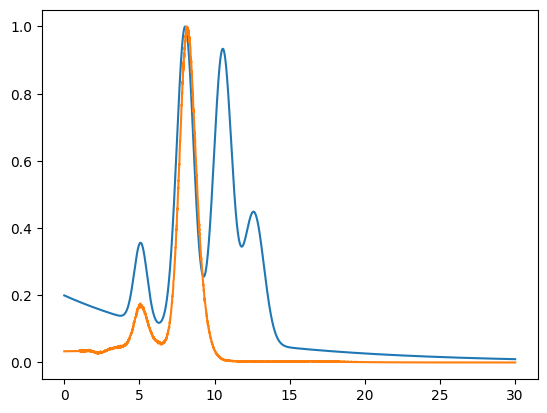

In [ ]:
# plt.plot(np.linspace(0,30, 4096), array - example_X[4])
plt.plot(np.linspace(0,30, 4096), example_X[0])
plt.plot(np.linspace(0,30, 4096), array)
y_pred = model(torch.tensor(example_X[11].reshape(1, 1, 4096)).float().to(DEVICE))[0]
print_y(y_pred.tolist())
print_y(example_y[11])
# loss = criterion(y_pred, example_y[0])
print(np.argmax(array))
print(np.argmax(example_X[0]))

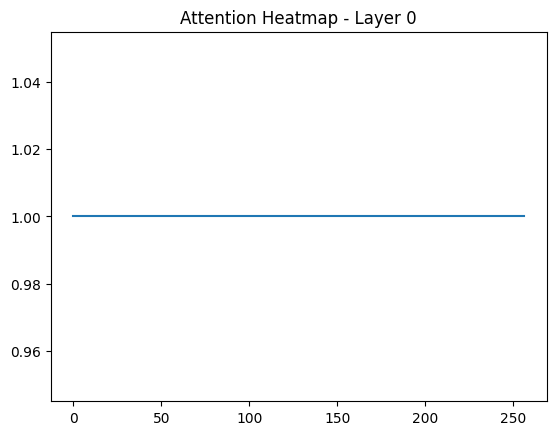

In [ ]:
model.eval()

# Run inference and extract attention weights
with torch.no_grad():
    output = model(torch.tensor(example_X[0].reshape(1, 1, 4096)).float().to(DEVICE))[0]
    attention_weights = model.transformer_blocks[5].attn_weights
    layer_index = 0  # Choose the layer for visualization
    attention_map = attention_weights[layer_index].squeeze().cpu().numpy()

    plt.plot(attention_weights.reshape(-1).tolist())
    plt.title(f'Attention Heatmap - Layer {layer_index}')
    plt.show()
